### Repeated Prisioner's Dilemma - Double Agent w/o discounting or state

- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or cooperate (C/1).
- Defect is dominant strategy, and (D,D) is Nash Eqbm of stage game. 
- Sustained Cooperation is best for everyone in repeated game. 
- Rewards for agents are 

    - (1,1) for (D,D) 
    - (3,0) for (D,C) 
    - (0,3) for (C,D) 
    - (2.5,2.5) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is no "discounting". Agents only value current profits - they do not seek to maximize discounted sum. 

### Import Packages

In [1]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [2]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (1,1)
    if (a1 == 0 and a2 == 1): # DC
        return (3,0)
    if (a1 == 1 and a2 == 0): # CD
        return (0,3)
    if (a1 == 1 and a2 == 1): # CC
        return (2.5,2.5)
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')

### HyperParameters and Initializations

In [3]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [4]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 10000
for t in range(epochs):
    print('\n Iteration:',t)
    # Take action
    a1 = select_action(state, policy_net1, 0)
    a2 = select_action(state, policy_net2, 1)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])

    # Compute next state
    next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)
    optimize_model(policy_net2,target_net2, 1)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    update_target_net(target_net2, policy_net2)
    
    # record actions
    actions.append([a1.item(),a2.item()])


 Iteration: 0

 Iteration: 1

 Iteration: 2

 Iteration: 3

 Iteration: 4

 Iteration: 5

 Iteration: 6

 Iteration: 7

 Iteration: 8

 Iteration: 9

 Iteration: 10

 Iteration: 11

 Iteration: 12

 Iteration: 13

 Iteration: 14

 Iteration: 15

 Iteration: 16

 Iteration: 17

 Iteration: 18

 Iteration: 19

 Iteration: 20

 Iteration: 21

 Iteration: 22

 Iteration: 23

 Iteration: 24

 Iteration: 25

 Iteration: 26

 Iteration: 27

 Iteration: 28

 Iteration: 29

 Iteration: 30

 Iteration: 31

 Iteration: 32

 Iteration: 33

 Iteration: 34

 Iteration: 35

 Iteration: 36

 Iteration: 37

 Iteration: 38

 Iteration: 39

 Iteration: 40

 Iteration: 41

 Iteration: 42

 Iteration: 43

 Iteration: 44

 Iteration: 45

 Iteration: 46

 Iteration: 47

 Iteration: 48

 Iteration: 49

 Iteration: 50

 Iteration: 51

 Iteration: 52

 Iteration: 53

 Iteration: 54

 Iteration: 55

 Iteration: 56

 Iteration: 57

 Iteration: 58

 Iteration: 59

 Iteration: 60

 Iteration: 61

 Iteration: 62

 

Loss Agent1:0.7954397201538086

 Iteration: 209
Loss Agent0:1.043231725692749
Loss Agent1:0.7003464102745056

 Iteration: 210
Loss Agent0:1.023443579673767
Loss Agent1:0.7459257245063782

 Iteration: 211
Loss Agent0:0.9982820153236389
Loss Agent1:0.7585303783416748

 Iteration: 212
Loss Agent0:1.0569876432418823
Loss Agent1:0.7803465723991394

 Iteration: 213
Loss Agent0:0.9783012866973877
Loss Agent1:0.7976065874099731

 Iteration: 214
Loss Agent0:0.9923526644706726
Loss Agent1:0.6918193101882935

 Iteration: 215
Loss Agent0:0.918117880821228
Loss Agent1:0.7453732490539551

 Iteration: 216
Loss Agent0:0.844689130783081
Loss Agent1:0.6906839609146118

 Iteration: 217
Loss Agent0:1.007500410079956
Loss Agent1:0.7182751297950745

 Iteration: 218
Loss Agent0:0.998175859451294
Loss Agent1:0.721565306186676

 Iteration: 219
Loss Agent0:0.9705784320831299
Loss Agent1:0.7163726091384888

 Iteration: 220
Loss Agent0:0.932102382183075
Loss Agent1:0.6960774660110474

 Iteration: 221
Loss Agent0:

Loss Agent0:0.6120293140411377
Loss Agent1:0.5452151298522949

 Iteration: 314
Loss Agent0:0.6152621507644653
Loss Agent1:0.5438072085380554

 Iteration: 315
Loss Agent0:0.683353841304779
Loss Agent1:0.561733067035675

 Iteration: 316
Loss Agent0:0.6496657729148865
Loss Agent1:0.5548150539398193

 Iteration: 317
Loss Agent0:0.6822741627693176
Loss Agent1:0.5040894746780396

 Iteration: 318
Loss Agent0:0.6304686069488525
Loss Agent1:0.6082063317298889

 Iteration: 319
Loss Agent0:0.6523124575614929
Loss Agent1:0.5926268696784973

 Iteration: 320
Loss Agent0:0.5975674390792847
Loss Agent1:0.5347474217414856

 Iteration: 321
Loss Agent0:0.6161201596260071
Loss Agent1:0.599464476108551

 Iteration: 322
Loss Agent0:0.6186490654945374
Loss Agent1:0.5029138326644897

 Iteration: 323
Loss Agent0:0.5807127952575684
Loss Agent1:0.49059703946113586

 Iteration: 324
Loss Agent0:0.6191235184669495
Loss Agent1:0.5166568160057068

 Iteration: 325
Loss Agent0:0.6251132488250732
Loss Agent1:0.499323070

Loss Agent0:0.5796748399734497
Loss Agent1:0.4864661693572998

 Iteration: 421
Loss Agent0:0.5659371018409729
Loss Agent1:0.5454314947128296

 Iteration: 422
Loss Agent0:0.5720686912536621
Loss Agent1:0.4558302164077759

 Iteration: 423
Loss Agent0:0.5914921164512634
Loss Agent1:0.5657706260681152

 Iteration: 424
Loss Agent0:0.5567909479141235
Loss Agent1:0.600482165813446

 Iteration: 425
Loss Agent0:0.5558363795280457
Loss Agent1:0.4790860712528229

 Iteration: 426
Loss Agent0:0.5793650150299072
Loss Agent1:0.5101273059844971

 Iteration: 427
Loss Agent0:0.5650179386138916
Loss Agent1:0.5012878179550171

 Iteration: 428
Loss Agent0:0.5749250054359436
Loss Agent1:0.5473494529724121

 Iteration: 429
Loss Agent0:0.5996537208557129
Loss Agent1:0.5831797122955322

 Iteration: 430
Loss Agent0:0.5391533970832825
Loss Agent1:0.42239952087402344

 Iteration: 431
Loss Agent0:0.5023332834243774
Loss Agent1:0.4884910583496094

 Iteration: 432
Loss Agent0:0.5777891874313354
Loss Agent1:0.5112680

Loss Agent1:0.4898451566696167

 Iteration: 531
Loss Agent0:0.46375060081481934
Loss Agent1:0.5033108592033386

 Iteration: 532
Loss Agent0:0.4958311915397644
Loss Agent1:0.5377006530761719

 Iteration: 533
Loss Agent0:0.5812824964523315
Loss Agent1:0.4948458969593048

 Iteration: 534
Loss Agent0:0.5042334794998169
Loss Agent1:0.4970766603946686

 Iteration: 535
Loss Agent0:0.5162485241889954
Loss Agent1:0.5572404861450195

 Iteration: 536
Loss Agent0:0.5235230922698975
Loss Agent1:0.5675591230392456

 Iteration: 537
Loss Agent0:0.5069759488105774
Loss Agent1:0.5066537261009216

 Iteration: 538
Loss Agent0:0.5870051980018616
Loss Agent1:0.5289726257324219

 Iteration: 539
Loss Agent0:0.5524502396583557
Loss Agent1:0.5158126950263977

 Iteration: 540
Loss Agent0:0.5573155879974365
Loss Agent1:0.5109962224960327

 Iteration: 541
Loss Agent0:0.5683313608169556
Loss Agent1:0.4990394115447998

 Iteration: 542
Loss Agent0:0.5367454290390015
Loss Agent1:0.4976911246776581

 Iteration: 543
Los


 Iteration: 641
Loss Agent0:0.46900975704193115
Loss Agent1:0.5125139951705933

 Iteration: 642
Loss Agent0:0.5058557391166687
Loss Agent1:0.45175522565841675

 Iteration: 643
Loss Agent0:0.5445194244384766
Loss Agent1:0.4239598214626312

 Iteration: 644
Loss Agent0:0.5018561482429504
Loss Agent1:0.47370797395706177

 Iteration: 645
Loss Agent0:0.5551868677139282
Loss Agent1:0.5003516674041748

 Iteration: 646
Loss Agent0:0.4743700623512268
Loss Agent1:0.4396182894706726

 Iteration: 647
Loss Agent0:0.47584566473960876
Loss Agent1:0.4848008453845978

 Iteration: 648
Loss Agent0:0.5144662857055664
Loss Agent1:0.44133299589157104

 Iteration: 649
Loss Agent0:0.4979199767112732
Loss Agent1:0.4818703234195709

 Iteration: 650
Loss Agent0:0.4887906014919281
Loss Agent1:0.5046566724777222

 Iteration: 651
Loss Agent0:0.5403828620910645
Loss Agent1:0.48445063829421997

 Iteration: 652
Loss Agent0:0.506476879119873
Loss Agent1:0.5015363097190857

 Iteration: 653
Loss Agent0:0.4967962205410003

Loss Agent0:0.4567369222640991
Loss Agent1:0.4491393566131592

 Iteration: 752
Loss Agent0:0.5242348909378052
Loss Agent1:0.4677659273147583

 Iteration: 753
Loss Agent0:0.5063896775245667
Loss Agent1:0.4817054569721222

 Iteration: 754
Loss Agent0:0.4869334101676941
Loss Agent1:0.5184482932090759

 Iteration: 755
Loss Agent0:0.5411936640739441
Loss Agent1:0.46716591715812683

 Iteration: 756
Loss Agent0:0.4526832699775696
Loss Agent1:0.47075480222702026

 Iteration: 757
Loss Agent0:0.5550764203071594
Loss Agent1:0.43776169419288635

 Iteration: 758
Loss Agent0:0.4847341775894165
Loss Agent1:0.4524822533130646

 Iteration: 759
Loss Agent0:0.44625887274742126
Loss Agent1:0.5527164936065674

 Iteration: 760
Loss Agent0:0.4822656512260437
Loss Agent1:0.48595359921455383

 Iteration: 761
Loss Agent0:0.5064780116081238
Loss Agent1:0.45314347743988037

 Iteration: 762
Loss Agent0:0.48955661058425903
Loss Agent1:0.4411464333534241

 Iteration: 763
Loss Agent0:0.5029895305633545
Loss Agent1:0.

Loss Agent0:0.447010338306427
Loss Agent1:0.42368218302726746

 Iteration: 856
Loss Agent0:0.4248248338699341
Loss Agent1:0.3920243978500366

 Iteration: 857
Loss Agent0:0.460000604391098
Loss Agent1:0.40612977743148804

 Iteration: 858
Loss Agent0:0.47586625814437866
Loss Agent1:0.48597219586372375

 Iteration: 859
Loss Agent0:0.5318618416786194
Loss Agent1:0.4523605704307556

 Iteration: 860
Loss Agent0:0.41254910826683044
Loss Agent1:0.4525081217288971

 Iteration: 861
Loss Agent0:0.46374332904815674
Loss Agent1:0.4261454939842224

 Iteration: 862
Loss Agent0:0.48768237233161926
Loss Agent1:0.4465083181858063

 Iteration: 863
Loss Agent0:0.45237308740615845
Loss Agent1:0.47850358486175537

 Iteration: 864
Loss Agent0:0.49337655305862427
Loss Agent1:0.47697991132736206

 Iteration: 865
Loss Agent0:0.5672709345817566
Loss Agent1:0.47177204489707947

 Iteration: 866
Loss Agent0:0.43143895268440247
Loss Agent1:0.41457390785217285

 Iteration: 867
Loss Agent0:0.5185035467147827
Loss Agen

Loss Agent0:0.46675288677215576
Loss Agent1:0.43315011262893677

 Iteration: 959
Loss Agent0:0.5064191818237305
Loss Agent1:0.43713605403900146

 Iteration: 960
Loss Agent0:0.4317399859428406
Loss Agent1:0.4294520318508148

 Iteration: 961
Loss Agent0:0.48386111855506897
Loss Agent1:0.46791937947273254

 Iteration: 962
Loss Agent0:0.44575464725494385
Loss Agent1:0.440261572599411

 Iteration: 963
Loss Agent0:0.4005112648010254
Loss Agent1:0.49330899119377136

 Iteration: 964
Loss Agent0:0.5040338039398193
Loss Agent1:0.4378476142883301

 Iteration: 965
Loss Agent0:0.3755037486553192
Loss Agent1:0.4600858986377716

 Iteration: 966
Loss Agent0:0.415244996547699
Loss Agent1:0.4288402199745178

 Iteration: 967
Loss Agent0:0.5204837322235107
Loss Agent1:0.49067747592926025

 Iteration: 968
Loss Agent0:0.4089697599411011
Loss Agent1:0.483000248670578

 Iteration: 969
Loss Agent0:0.4221791625022888
Loss Agent1:0.48625609278678894

 Iteration: 970
Loss Agent0:0.43089625239372253
Loss Agent1:0.

Loss Agent1:0.45595210790634155

 Iteration: 1066
Loss Agent0:0.519268274307251
Loss Agent1:0.46732908487319946

 Iteration: 1067
Loss Agent0:0.40333765745162964
Loss Agent1:0.43740057945251465

 Iteration: 1068
Loss Agent0:0.5532668232917786
Loss Agent1:0.4556923508644104

 Iteration: 1069
Loss Agent0:0.46777114272117615
Loss Agent1:0.3689342439174652

 Iteration: 1070
Loss Agent0:0.4377657175064087
Loss Agent1:0.39575791358947754

 Iteration: 1071
Loss Agent0:0.47498172521591187
Loss Agent1:0.45189255475997925

 Iteration: 1072
Loss Agent0:0.44418102502822876
Loss Agent1:0.4479777216911316

 Iteration: 1073
Loss Agent0:0.4854150712490082
Loss Agent1:0.5134115219116211

 Iteration: 1074
Loss Agent0:0.4741800129413605
Loss Agent1:0.4975000321865082

 Iteration: 1075
Loss Agent0:0.4334796667098999
Loss Agent1:0.4983865022659302

 Iteration: 1076
Loss Agent0:0.5225755572319031
Loss Agent1:0.4750015139579773

 Iteration: 1077
Loss Agent0:0.4190669059753418
Loss Agent1:0.4109775125980377



Loss Agent1:0.4257988929748535

 Iteration: 1169
Loss Agent0:0.3894246518611908
Loss Agent1:0.464042603969574

 Iteration: 1170
Loss Agent0:0.40769022703170776
Loss Agent1:0.4144776463508606

 Iteration: 1171
Loss Agent0:0.3442319929599762
Loss Agent1:0.3765779137611389

 Iteration: 1172
Loss Agent0:0.4217239320278168
Loss Agent1:0.4178470969200134

 Iteration: 1173
Loss Agent0:0.39946192502975464
Loss Agent1:0.5249596238136292

 Iteration: 1174
Loss Agent0:0.463093638420105
Loss Agent1:0.3566668629646301

 Iteration: 1175
Loss Agent0:0.4930833876132965
Loss Agent1:0.40658679604530334

 Iteration: 1176
Loss Agent0:0.42894285917282104
Loss Agent1:0.4412304162979126

 Iteration: 1177
Loss Agent0:0.44861704111099243
Loss Agent1:0.4141942262649536

 Iteration: 1178
Loss Agent0:0.41400760412216187
Loss Agent1:0.4251132011413574

 Iteration: 1179
Loss Agent0:0.4371836185455322
Loss Agent1:0.45250970125198364

 Iteration: 1180
Loss Agent0:0.3742089867591858
Loss Agent1:0.35677433013916016

 I

Loss Agent1:0.41867056488990784

 Iteration: 1277
Loss Agent0:0.38036537170410156
Loss Agent1:0.42556503415107727

 Iteration: 1278
Loss Agent0:0.33321624994277954
Loss Agent1:0.3667132556438446

 Iteration: 1279
Loss Agent0:0.5006634593009949
Loss Agent1:0.44120171666145325

 Iteration: 1280
Loss Agent0:0.3969423174858093
Loss Agent1:0.3058527410030365

 Iteration: 1281
Loss Agent0:0.4065850079059601
Loss Agent1:0.41393759846687317

 Iteration: 1282
Loss Agent0:0.47787001729011536
Loss Agent1:0.4262904226779938

 Iteration: 1283
Loss Agent0:0.5068643093109131
Loss Agent1:0.4213569164276123

 Iteration: 1284
Loss Agent0:0.4493699073791504
Loss Agent1:0.46581265330314636

 Iteration: 1285
Loss Agent0:0.3806912899017334
Loss Agent1:0.4497702121734619

 Iteration: 1286
Loss Agent0:0.38679057359695435
Loss Agent1:0.39045315980911255

 Iteration: 1287
Loss Agent0:0.4339088499546051
Loss Agent1:0.4022350013256073

 Iteration: 1288
Loss Agent0:0.4018344283103943
Loss Agent1:0.4623321890830993

Loss Agent0:0.3930198550224304
Loss Agent1:0.4924463927745819

 Iteration: 1383
Loss Agent0:0.3999645411968231
Loss Agent1:0.3565974235534668

 Iteration: 1384
Loss Agent0:0.4544699788093567
Loss Agent1:0.33573105931282043

 Iteration: 1385
Loss Agent0:0.398546040058136
Loss Agent1:0.33938995003700256

 Iteration: 1386
Loss Agent0:0.4506928026676178
Loss Agent1:0.4019300639629364

 Iteration: 1387
Loss Agent0:0.35016924142837524
Loss Agent1:0.357860267162323

 Iteration: 1388
Loss Agent0:0.36254775524139404
Loss Agent1:0.46092432737350464

 Iteration: 1389
Loss Agent0:0.4036482274532318
Loss Agent1:0.37838616967201233

 Iteration: 1390
Loss Agent0:0.43329620361328125
Loss Agent1:0.3504682183265686

 Iteration: 1391
Loss Agent0:0.42773962020874023
Loss Agent1:0.44550222158432007

 Iteration: 1392
Loss Agent0:0.4860246777534485
Loss Agent1:0.3553868234157562

 Iteration: 1393
Loss Agent0:0.45552483201026917
Loss Agent1:0.3536774218082428

 Iteration: 1394
Loss Agent0:0.40037065744400024


Loss Agent0:0.3676033914089203
Loss Agent1:0.3571900725364685

 Iteration: 1491
Loss Agent0:0.3599162697792053
Loss Agent1:0.3641595244407654

 Iteration: 1492
Loss Agent0:0.3894864320755005
Loss Agent1:0.3533475995063782

 Iteration: 1493
Loss Agent0:0.2719902992248535
Loss Agent1:0.3678698241710663

 Iteration: 1494
Loss Agent0:0.4344393014907837
Loss Agent1:0.3321406841278076

 Iteration: 1495
Loss Agent0:0.4037138521671295
Loss Agent1:0.4016388952732086

 Iteration: 1496
Loss Agent0:0.3702853322029114
Loss Agent1:0.46414002776145935

 Iteration: 1497
Loss Agent0:0.41237738728523254
Loss Agent1:0.37046703696250916

 Iteration: 1498
Loss Agent0:0.3799794912338257
Loss Agent1:0.3046639859676361

 Iteration: 1499
Loss Agent0:0.37104934453964233
Loss Agent1:0.40561020374298096

 Iteration: 1500
Loss Agent0:0.45263606309890747
Loss Agent1:0.3677468001842499

 Iteration: 1501
Loss Agent0:0.4223443567752838
Loss Agent1:0.3814348578453064

 Iteration: 1502
Loss Agent0:0.3658221662044525
Los

Loss Agent0:0.3768337666988373
Loss Agent1:0.3548075556755066

 Iteration: 1596
Loss Agent0:0.35582268238067627
Loss Agent1:0.48060548305511475

 Iteration: 1597
Loss Agent0:0.3423675000667572
Loss Agent1:0.34657251834869385

 Iteration: 1598
Loss Agent0:0.2903742492198944
Loss Agent1:0.34699687361717224

 Iteration: 1599
Loss Agent0:0.3360084295272827
Loss Agent1:0.44964462518692017

 Iteration: 1600
Loss Agent0:0.41342824697494507
Loss Agent1:0.3492797613143921

 Iteration: 1601
Loss Agent0:0.3658657670021057
Loss Agent1:0.41683337092399597

 Iteration: 1602
Loss Agent0:0.4181962013244629
Loss Agent1:0.3929777145385742

 Iteration: 1603
Loss Agent0:0.36443135142326355
Loss Agent1:0.37600433826446533

 Iteration: 1604
Loss Agent0:0.2671980857849121
Loss Agent1:0.3778917193412781

 Iteration: 1605
Loss Agent0:0.4179047644138336
Loss Agent1:0.3282313942909241

 Iteration: 1606
Loss Agent0:0.35925257205963135
Loss Agent1:0.32505863904953003

 Iteration: 1607
Loss Agent0:0.435325622558593

Loss Agent0:0.4279440641403198
Loss Agent1:0.3431566655635834

 Iteration: 1704
Loss Agent0:0.3641836643218994
Loss Agent1:0.3831919729709625

 Iteration: 1705
Loss Agent0:0.3704375624656677
Loss Agent1:0.4005117416381836

 Iteration: 1706
Loss Agent0:0.3959076702594757
Loss Agent1:0.2972359359264374

 Iteration: 1707
Loss Agent0:0.40585821866989136
Loss Agent1:0.39827167987823486

 Iteration: 1708
Loss Agent0:0.3732828199863434
Loss Agent1:0.4147099256515503

 Iteration: 1709
Loss Agent0:0.3661753535270691
Loss Agent1:0.3596537411212921

 Iteration: 1710
Loss Agent0:0.45055267214775085
Loss Agent1:0.3004893362522125

 Iteration: 1711
Loss Agent0:0.3484620451927185
Loss Agent1:0.40123450756073

 Iteration: 1712
Loss Agent0:0.3718697428703308
Loss Agent1:0.34444916248321533

 Iteration: 1713
Loss Agent0:0.27821049094200134
Loss Agent1:0.35905468463897705

 Iteration: 1714
Loss Agent0:0.3977232277393341
Loss Agent1:0.33861809968948364

 Iteration: 1715
Loss Agent0:0.37932485342025757
Los

Loss Agent0:0.33572059869766235
Loss Agent1:0.34707149863243103

 Iteration: 1810
Loss Agent0:0.3267797529697418
Loss Agent1:0.3561112582683563

 Iteration: 1811
Loss Agent0:0.34783729910850525
Loss Agent1:0.3440914452075958

 Iteration: 1812
Loss Agent0:0.25616776943206787
Loss Agent1:0.38026195764541626

 Iteration: 1813
Loss Agent0:0.2896636128425598
Loss Agent1:0.3368167579174042

 Iteration: 1814
Loss Agent0:0.41836872696876526
Loss Agent1:0.4026086628437042

 Iteration: 1815
Loss Agent0:0.3411721885204315
Loss Agent1:0.35759517550468445

 Iteration: 1816
Loss Agent0:0.3228146731853485
Loss Agent1:0.36219078302383423

 Iteration: 1817
Loss Agent0:0.3460102081298828
Loss Agent1:0.36774617433547974

 Iteration: 1818
Loss Agent0:0.32489636540412903
Loss Agent1:0.3961668610572815

 Iteration: 1819
Loss Agent0:0.38993895053863525
Loss Agent1:0.23349955677986145

 Iteration: 1820
Loss Agent0:0.39687252044677734
Loss Agent1:0.3828967809677124

 Iteration: 1821
Loss Agent0:0.2808744311332

Loss Agent1:0.3888177275657654

 Iteration: 1919
Loss Agent0:0.4558161497116089
Loss Agent1:0.32668831944465637

 Iteration: 1920
Loss Agent0:0.46801409125328064
Loss Agent1:0.30963385105133057

 Iteration: 1921
Loss Agent0:0.37985992431640625
Loss Agent1:0.31380099058151245

 Iteration: 1922
Loss Agent0:0.4065430462360382
Loss Agent1:0.2809160053730011

 Iteration: 1923
Loss Agent0:0.3395708203315735
Loss Agent1:0.3194182515144348

 Iteration: 1924
Loss Agent0:0.32894113659858704
Loss Agent1:0.4035460352897644

 Iteration: 1925
Loss Agent0:0.28697535395622253
Loss Agent1:0.23729485273361206

 Iteration: 1926
Loss Agent0:0.3310143053531647
Loss Agent1:0.3888504207134247

 Iteration: 1927
Loss Agent0:0.40043264627456665
Loss Agent1:0.3509412705898285

 Iteration: 1928
Loss Agent0:0.382222443819046
Loss Agent1:0.3469483256340027

 Iteration: 1929
Loss Agent0:0.33813801407814026
Loss Agent1:0.3651098906993866

 Iteration: 1930
Loss Agent0:0.3013041913509369
Loss Agent1:0.4138292074203491


Loss Agent0:0.2441606968641281
Loss Agent1:0.32841184735298157

 Iteration: 2023
Loss Agent0:0.32107895612716675
Loss Agent1:0.3693348169326782

 Iteration: 2024
Loss Agent0:0.30708661675453186
Loss Agent1:0.2825670838356018

 Iteration: 2025
Loss Agent0:0.3185572922229767
Loss Agent1:0.34560900926589966

 Iteration: 2026
Loss Agent0:0.32949262857437134
Loss Agent1:0.31083202362060547

 Iteration: 2027
Loss Agent0:0.32901865243911743
Loss Agent1:0.4042401909828186

 Iteration: 2028
Loss Agent0:0.3525535464286804
Loss Agent1:0.3242109715938568

 Iteration: 2029
Loss Agent0:0.3817552328109741
Loss Agent1:0.3315492868423462

 Iteration: 2030
Loss Agent0:0.2751353979110718
Loss Agent1:0.31790560483932495

 Iteration: 2031
Loss Agent0:0.3004586696624756
Loss Agent1:0.412804514169693

 Iteration: 2032
Loss Agent0:0.33501970767974854
Loss Agent1:0.3116476237773895

 Iteration: 2033
Loss Agent0:0.3493199348449707
Loss Agent1:0.3421066403388977

 Iteration: 2034
Loss Agent0:0.374921053647995
Lo

Loss Agent0:0.28004854917526245
Loss Agent1:0.2939061224460602

 Iteration: 2132
Loss Agent0:0.3546323776245117
Loss Agent1:0.2883286774158478

 Iteration: 2133
Loss Agent0:0.288535475730896
Loss Agent1:0.2579370141029358

 Iteration: 2134
Loss Agent0:0.29700326919555664
Loss Agent1:0.3371712565422058

 Iteration: 2135
Loss Agent0:0.37425941228866577
Loss Agent1:0.28454044461250305

 Iteration: 2136
Loss Agent0:0.38767313957214355
Loss Agent1:0.35683730244636536

 Iteration: 2137
Loss Agent0:0.3330622613430023
Loss Agent1:0.2967202961444855

 Iteration: 2138
Loss Agent0:0.3650447428226471
Loss Agent1:0.304679274559021

 Iteration: 2139
Loss Agent0:0.22526590526103973
Loss Agent1:0.3155575394630432

 Iteration: 2140
Loss Agent0:0.3148205280303955
Loss Agent1:0.30587753653526306

 Iteration: 2141
Loss Agent0:0.3465188443660736
Loss Agent1:0.25775331258773804

 Iteration: 2142
Loss Agent0:0.3214147984981537
Loss Agent1:0.34562692046165466

 Iteration: 2143
Loss Agent0:0.3428764045238495
L

Loss Agent1:0.3715544641017914

 Iteration: 2237
Loss Agent0:0.2249641716480255
Loss Agent1:0.2874417006969452

 Iteration: 2238
Loss Agent0:0.27615898847579956
Loss Agent1:0.28994181752204895

 Iteration: 2239
Loss Agent0:0.3594561815261841
Loss Agent1:0.3850642740726471

 Iteration: 2240
Loss Agent0:0.42415690422058105
Loss Agent1:0.291812539100647

 Iteration: 2241
Loss Agent0:0.21990516781806946
Loss Agent1:0.28848975896835327

 Iteration: 2242
Loss Agent0:0.40142175555229187
Loss Agent1:0.309707373380661

 Iteration: 2243
Loss Agent0:0.2727675437927246
Loss Agent1:0.2448159158229828

 Iteration: 2244
Loss Agent0:0.3087186813354492
Loss Agent1:0.2859644591808319

 Iteration: 2245
Loss Agent0:0.2803690433502197
Loss Agent1:0.33229154348373413

 Iteration: 2246
Loss Agent0:0.31413131952285767
Loss Agent1:0.33372145891189575

 Iteration: 2247
Loss Agent0:0.3363713324069977
Loss Agent1:0.31519806385040283

 Iteration: 2248
Loss Agent0:0.3066273629665375
Loss Agent1:0.3327973484992981



Loss Agent0:0.19187544286251068
Loss Agent1:0.2330217808485031

 Iteration: 2343
Loss Agent0:0.23283544182777405
Loss Agent1:0.291080117225647

 Iteration: 2344
Loss Agent0:0.3549058735370636
Loss Agent1:0.2537044286727905

 Iteration: 2345
Loss Agent0:0.27301204204559326
Loss Agent1:0.256727933883667

 Iteration: 2346
Loss Agent0:0.36251765489578247
Loss Agent1:0.2908346951007843

 Iteration: 2347
Loss Agent0:0.2908606231212616
Loss Agent1:0.30888986587524414

 Iteration: 2348
Loss Agent0:0.2628774642944336
Loss Agent1:0.37599241733551025

 Iteration: 2349
Loss Agent0:0.2910027503967285
Loss Agent1:0.2742856740951538

 Iteration: 2350
Loss Agent0:0.26339980959892273
Loss Agent1:0.31479495763778687

 Iteration: 2351
Loss Agent0:0.3287530541419983
Loss Agent1:0.24045756459236145

 Iteration: 2352
Loss Agent0:0.38287588953971863
Loss Agent1:0.28601589798927307

 Iteration: 2353
Loss Agent0:0.3440374732017517
Loss Agent1:0.3728557527065277

 Iteration: 2354
Loss Agent0:0.3074960708618164


Loss Agent0:0.2469027042388916
Loss Agent1:0.3734099566936493

 Iteration: 2445
Loss Agent0:0.27691978216171265
Loss Agent1:0.3254801630973816

 Iteration: 2446
Loss Agent0:0.24533462524414062
Loss Agent1:0.35956400632858276

 Iteration: 2447
Loss Agent0:0.27246832847595215
Loss Agent1:0.3111494183540344

 Iteration: 2448
Loss Agent0:0.2913556396961212
Loss Agent1:0.24078398942947388

 Iteration: 2449
Loss Agent0:0.27353036403656006
Loss Agent1:0.2611860930919647

 Iteration: 2450
Loss Agent0:0.25620755553245544
Loss Agent1:0.27308154106140137

 Iteration: 2451
Loss Agent0:0.28200215101242065
Loss Agent1:0.2533140480518341

 Iteration: 2452
Loss Agent0:0.27664685249328613
Loss Agent1:0.23939387500286102

 Iteration: 2453
Loss Agent0:0.32094886898994446
Loss Agent1:0.2799914479255676

 Iteration: 2454
Loss Agent0:0.2576785981655121
Loss Agent1:0.32339024543762207

 Iteration: 2455
Loss Agent0:0.27551209926605225
Loss Agent1:0.2502543330192566

 Iteration: 2456
Loss Agent0:0.341081708669

Loss Agent0:0.2798534631729126
Loss Agent1:0.2792476415634155

 Iteration: 2549
Loss Agent0:0.30966717004776
Loss Agent1:0.2719116508960724

 Iteration: 2550
Loss Agent0:0.2841891646385193
Loss Agent1:0.2721240520477295

 Iteration: 2551
Loss Agent0:0.2996598780155182
Loss Agent1:0.24612656235694885

 Iteration: 2552
Loss Agent0:0.3350162208080292
Loss Agent1:0.20800842344760895

 Iteration: 2553
Loss Agent0:0.3309563398361206
Loss Agent1:0.24355082213878632

 Iteration: 2554
Loss Agent0:0.24381406605243683
Loss Agent1:0.2786152958869934

 Iteration: 2555
Loss Agent0:0.27636122703552246
Loss Agent1:0.28438544273376465

 Iteration: 2556
Loss Agent0:0.3035643696784973
Loss Agent1:0.28375178575515747

 Iteration: 2557
Loss Agent0:0.2895926237106323
Loss Agent1:0.2929084300994873

 Iteration: 2558
Loss Agent0:0.37333664298057556
Loss Agent1:0.23495057225227356

 Iteration: 2559
Loss Agent0:0.2520608901977539
Loss Agent1:0.25088679790496826

 Iteration: 2560
Loss Agent0:0.27812349796295166


Loss Agent0:0.3899846374988556
Loss Agent1:0.2914198637008667

 Iteration: 2658
Loss Agent0:0.23611634969711304
Loss Agent1:0.27491793036460876

 Iteration: 2659
Loss Agent0:0.23290959000587463
Loss Agent1:0.29617270827293396

 Iteration: 2660
Loss Agent0:0.2988182604312897
Loss Agent1:0.3221401870250702

 Iteration: 2661
Loss Agent0:0.32290345430374146
Loss Agent1:0.2493416666984558

 Iteration: 2662
Loss Agent0:0.23316897451877594
Loss Agent1:0.30494099855422974

 Iteration: 2663
Loss Agent0:0.2921304702758789
Loss Agent1:0.25530898571014404

 Iteration: 2664
Loss Agent0:0.274230033159256
Loss Agent1:0.2055506557226181

 Iteration: 2665
Loss Agent0:0.28541451692581177
Loss Agent1:0.2092447280883789

 Iteration: 2666
Loss Agent0:0.30422282218933105
Loss Agent1:0.24108918011188507

 Iteration: 2667
Loss Agent0:0.41652536392211914
Loss Agent1:0.28074872493743896

 Iteration: 2668
Loss Agent0:0.24449241161346436
Loss Agent1:0.35953855514526367

 Iteration: 2669
Loss Agent0:0.218521595001

Loss Agent0:0.21883414685726166
Loss Agent1:0.2483343482017517

 Iteration: 2762
Loss Agent0:0.2755269408226013
Loss Agent1:0.34268268942832947

 Iteration: 2763
Loss Agent0:0.29633596539497375
Loss Agent1:0.19674229621887207

 Iteration: 2764
Loss Agent0:0.21241888403892517
Loss Agent1:0.2708905339241028

 Iteration: 2765
Loss Agent0:0.27735796570777893
Loss Agent1:0.2884069085121155

 Iteration: 2766
Loss Agent0:0.28078344464302063
Loss Agent1:0.26199373602867126

 Iteration: 2767
Loss Agent0:0.2292143851518631
Loss Agent1:0.29238542914390564

 Iteration: 2768
Loss Agent0:0.2869010865688324
Loss Agent1:0.2513103783130646

 Iteration: 2769
Loss Agent0:0.31007862091064453
Loss Agent1:0.2541997730731964

 Iteration: 2770
Loss Agent0:0.2589491903781891
Loss Agent1:0.2660693824291229

 Iteration: 2771
Loss Agent0:0.29478615522384644
Loss Agent1:0.18661081790924072

 Iteration: 2772
Loss Agent0:0.2925753593444824
Loss Agent1:0.34455153346061707

 Iteration: 2773
Loss Agent0:0.2481596618890

Loss Agent0:0.35445940494537354
Loss Agent1:0.23468180000782013

 Iteration: 2866
Loss Agent0:0.2952759265899658
Loss Agent1:0.2759258449077606

 Iteration: 2867
Loss Agent0:0.3469618856906891
Loss Agent1:0.17775622010231018

 Iteration: 2868
Loss Agent0:0.23284661769866943
Loss Agent1:0.26782742142677307

 Iteration: 2869
Loss Agent0:0.28642168641090393
Loss Agent1:0.33172133564949036

 Iteration: 2870
Loss Agent0:0.2636926770210266
Loss Agent1:0.25508418679237366

 Iteration: 2871
Loss Agent0:0.21738913655281067
Loss Agent1:0.16418397426605225

 Iteration: 2872
Loss Agent0:0.24871395528316498
Loss Agent1:0.2963114082813263

 Iteration: 2873
Loss Agent0:0.27544403076171875
Loss Agent1:0.2827640473842621

 Iteration: 2874
Loss Agent0:0.23983336985111237
Loss Agent1:0.21239358186721802

 Iteration: 2875
Loss Agent0:0.15468309819698334
Loss Agent1:0.33713021874427795

 Iteration: 2876
Loss Agent0:0.3147438168525696
Loss Agent1:0.24494905769824982

 Iteration: 2877
Loss Agent0:0.270130485

Loss Agent0:0.34863531589508057
Loss Agent1:0.15398269891738892

 Iteration: 2972
Loss Agent0:0.21825145184993744
Loss Agent1:0.341697633266449

 Iteration: 2973
Loss Agent0:0.31374654173851013
Loss Agent1:0.2548905611038208

 Iteration: 2974
Loss Agent0:0.2667869031429291
Loss Agent1:0.2961686849594116

 Iteration: 2975
Loss Agent0:0.16440780460834503
Loss Agent1:0.33335092663764954

 Iteration: 2976
Loss Agent0:0.25606590509414673
Loss Agent1:0.29527589678764343

 Iteration: 2977
Loss Agent0:0.2852930724620819
Loss Agent1:0.18840134143829346

 Iteration: 2978
Loss Agent0:0.2731447219848633
Loss Agent1:0.2698650658130646

 Iteration: 2979
Loss Agent0:0.29431992769241333
Loss Agent1:0.22686335444450378

 Iteration: 2980
Loss Agent0:0.2088315635919571
Loss Agent1:0.23455023765563965

 Iteration: 2981
Loss Agent0:0.24015311896800995
Loss Agent1:0.23983041942119598

 Iteration: 2982
Loss Agent0:0.28855958580970764
Loss Agent1:0.21044015884399414

 Iteration: 2983
Loss Agent0:0.27078139781

Loss Agent0:0.29280486702919006
Loss Agent1:0.2970660924911499

 Iteration: 3074
Loss Agent0:0.27177760004997253
Loss Agent1:0.16910117864608765

 Iteration: 3075
Loss Agent0:0.29005715250968933
Loss Agent1:0.24900859594345093

 Iteration: 3076
Loss Agent0:0.22700342535972595
Loss Agent1:0.23599261045455933

 Iteration: 3077
Loss Agent0:0.28642216324806213
Loss Agent1:0.22668014466762543

 Iteration: 3078
Loss Agent0:0.27429357171058655
Loss Agent1:0.19854842126369476

 Iteration: 3079
Loss Agent0:0.24639496207237244
Loss Agent1:0.29767781496047974

 Iteration: 3080
Loss Agent0:0.25260743498802185
Loss Agent1:0.26910200715065

 Iteration: 3081
Loss Agent0:0.34959787130355835
Loss Agent1:0.301064670085907

 Iteration: 3082
Loss Agent0:0.2273498773574829
Loss Agent1:0.1784653663635254

 Iteration: 3083
Loss Agent0:0.33166980743408203
Loss Agent1:0.3683229684829712

 Iteration: 3084
Loss Agent0:0.16407790780067444
Loss Agent1:0.2930941879749298

 Iteration: 3085
Loss Agent0:0.234698832035

Loss Agent1:0.21610158681869507

 Iteration: 3177
Loss Agent0:0.19659022986888885
Loss Agent1:0.2561328113079071

 Iteration: 3178
Loss Agent0:0.3039283752441406
Loss Agent1:0.18507489562034607

 Iteration: 3179
Loss Agent0:0.21471944451332092
Loss Agent1:0.3154880702495575

 Iteration: 3180
Loss Agent0:0.288191556930542
Loss Agent1:0.24881435930728912

 Iteration: 3181
Loss Agent0:0.26130324602127075
Loss Agent1:0.22015707194805145

 Iteration: 3182
Loss Agent0:0.26790979504585266
Loss Agent1:0.20632514357566833

 Iteration: 3183
Loss Agent0:0.26183679699897766
Loss Agent1:0.31371259689331055

 Iteration: 3184
Loss Agent0:0.2199876606464386
Loss Agent1:0.2110174596309662

 Iteration: 3185
Loss Agent0:0.24215447902679443
Loss Agent1:0.2292054295539856

 Iteration: 3186
Loss Agent0:0.2172316014766693
Loss Agent1:0.28658169507980347

 Iteration: 3187
Loss Agent0:0.2745741307735443
Loss Agent1:0.196740061044693

 Iteration: 3188
Loss Agent0:0.2290797084569931
Loss Agent1:0.263103455305099

Loss Agent0:0.20603980123996735
Loss Agent1:0.20729830861091614

 Iteration: 3280
Loss Agent0:0.2636267840862274
Loss Agent1:0.25853535532951355

 Iteration: 3281
Loss Agent0:0.218524768948555
Loss Agent1:0.36365368962287903

 Iteration: 3282
Loss Agent0:0.2919795513153076
Loss Agent1:0.1823955774307251

 Iteration: 3283
Loss Agent0:0.20938155055046082
Loss Agent1:0.25582534074783325

 Iteration: 3284
Loss Agent0:0.2812812328338623
Loss Agent1:0.21980080008506775

 Iteration: 3285
Loss Agent0:0.26155659556388855
Loss Agent1:0.18111546337604523

 Iteration: 3286
Loss Agent0:0.2862662374973297
Loss Agent1:0.25630155205726624

 Iteration: 3287
Loss Agent0:0.2510499358177185
Loss Agent1:0.20171409845352173

 Iteration: 3288
Loss Agent0:0.1902887225151062
Loss Agent1:0.2112407088279724

 Iteration: 3289
Loss Agent0:0.1960963010787964
Loss Agent1:0.20118455588817596

 Iteration: 3290
Loss Agent0:0.252154678106308
Loss Agent1:0.23901242017745972

 Iteration: 3291
Loss Agent0:0.318548798561096

Loss Agent0:0.1961977779865265
Loss Agent1:0.25778958201408386

 Iteration: 3386
Loss Agent0:0.2202184498310089
Loss Agent1:0.1865965723991394

 Iteration: 3387
Loss Agent0:0.19314110279083252
Loss Agent1:0.2760089635848999

 Iteration: 3388
Loss Agent0:0.23766179382801056
Loss Agent1:0.24255181849002838

 Iteration: 3389
Loss Agent0:0.3037271499633789
Loss Agent1:0.18487845361232758

 Iteration: 3390
Loss Agent0:0.2539535462856293
Loss Agent1:0.22676795721054077

 Iteration: 3391
Loss Agent0:0.22527135908603668
Loss Agent1:0.28208667039871216

 Iteration: 3392
Loss Agent0:0.37322694063186646
Loss Agent1:0.2585040330886841

 Iteration: 3393
Loss Agent0:0.19861724972724915
Loss Agent1:0.22379912436008453

 Iteration: 3394
Loss Agent0:0.21100415289402008
Loss Agent1:0.18585003912448883

 Iteration: 3395
Loss Agent0:0.15942813456058502
Loss Agent1:0.21859733760356903

 Iteration: 3396
Loss Agent0:0.26006895303726196
Loss Agent1:0.18395847082138062

 Iteration: 3397
Loss Agent0:0.247341871

Loss Agent1:0.24388743937015533

 Iteration: 3488
Loss Agent0:0.21212588250637054
Loss Agent1:0.25397390127182007

 Iteration: 3489
Loss Agent0:0.26681023836135864
Loss Agent1:0.23116903007030487

 Iteration: 3490
Loss Agent0:0.2788293659687042
Loss Agent1:0.25377434492111206

 Iteration: 3491
Loss Agent0:0.17082591354846954
Loss Agent1:0.2514674663543701

 Iteration: 3492
Loss Agent0:0.20361542701721191
Loss Agent1:0.21621659398078918

 Iteration: 3493
Loss Agent0:0.2572101950645447
Loss Agent1:0.20328256487846375

 Iteration: 3494
Loss Agent0:0.2135765254497528
Loss Agent1:0.2787778079509735

 Iteration: 3495
Loss Agent0:0.2124338299036026
Loss Agent1:0.19470298290252686

 Iteration: 3496
Loss Agent0:0.2155962735414505
Loss Agent1:0.26642805337905884

 Iteration: 3497
Loss Agent0:0.1329890638589859
Loss Agent1:0.21116608381271362

 Iteration: 3498
Loss Agent0:0.17702922224998474
Loss Agent1:0.11868474632501602

 Iteration: 3499
Loss Agent0:0.14217980206012726
Loss Agent1:0.2194102406

Loss Agent0:0.26135191321372986
Loss Agent1:0.26459383964538574

 Iteration: 3593
Loss Agent0:0.24105601012706757
Loss Agent1:0.2018570750951767

 Iteration: 3594
Loss Agent0:0.22139745950698853
Loss Agent1:0.25993621349334717

 Iteration: 3595
Loss Agent0:0.22680163383483887
Loss Agent1:0.2610447406768799

 Iteration: 3596
Loss Agent0:0.2141433209180832
Loss Agent1:0.27768057584762573

 Iteration: 3597
Loss Agent0:0.2664582133293152
Loss Agent1:0.19595567882061005

 Iteration: 3598
Loss Agent0:0.236989825963974
Loss Agent1:0.2573195695877075

 Iteration: 3599
Loss Agent0:0.25603100657463074
Loss Agent1:0.16636031866073608

 Iteration: 3600
Loss Agent0:0.2547304630279541
Loss Agent1:0.19391730427742004

 Iteration: 3601
Loss Agent0:0.22815048694610596
Loss Agent1:0.24287252128124237

 Iteration: 3602
Loss Agent0:0.2669524550437927
Loss Agent1:0.25568386912345886

 Iteration: 3603
Loss Agent0:0.29701778292655945
Loss Agent1:0.20488065481185913

 Iteration: 3604
Loss Agent0:0.23485644161

Loss Agent0:0.2692439556121826
Loss Agent1:0.19290775060653687

 Iteration: 3698
Loss Agent0:0.21181361377239227
Loss Agent1:0.2806105613708496

 Iteration: 3699
Loss Agent0:0.25496816635131836
Loss Agent1:0.24560588598251343

 Iteration: 3700
Loss Agent0:0.24966497719287872
Loss Agent1:0.1881861388683319

 Iteration: 3701
Loss Agent0:0.18941853940486908
Loss Agent1:0.2332426756620407

 Iteration: 3702
Loss Agent0:0.17924731969833374
Loss Agent1:0.28726500272750854

 Iteration: 3703
Loss Agent0:0.256521075963974
Loss Agent1:0.21293823421001434

 Iteration: 3704
Loss Agent0:0.1728762984275818
Loss Agent1:0.23896151781082153

 Iteration: 3705
Loss Agent0:0.22785347700119019
Loss Agent1:0.2138756364583969

 Iteration: 3706
Loss Agent0:0.1647837907075882
Loss Agent1:0.19450442492961884

 Iteration: 3707
Loss Agent0:0.24290186166763306
Loss Agent1:0.26411116123199463

 Iteration: 3708
Loss Agent0:0.16959011554718018
Loss Agent1:0.22818633913993835

 Iteration: 3709
Loss Agent0:0.22127234935


 Iteration: 3800
Loss Agent0:0.2854882478713989
Loss Agent1:0.2038998156785965

 Iteration: 3801
Loss Agent0:0.1785997599363327
Loss Agent1:0.22928078472614288

 Iteration: 3802
Loss Agent0:0.18235912919044495
Loss Agent1:0.1466318517923355

 Iteration: 3803
Loss Agent0:0.144745334982872
Loss Agent1:0.1318606585264206

 Iteration: 3804
Loss Agent0:0.1831960827112198
Loss Agent1:0.2289046198129654

 Iteration: 3805
Loss Agent0:0.19523003697395325
Loss Agent1:0.18635855615139008

 Iteration: 3806
Loss Agent0:0.197616845369339
Loss Agent1:0.250593364238739

 Iteration: 3807
Loss Agent0:0.1642855852842331
Loss Agent1:0.231033593416214

 Iteration: 3808
Loss Agent0:0.18726880848407745
Loss Agent1:0.21525736153125763

 Iteration: 3809
Loss Agent0:0.2878151535987854
Loss Agent1:0.2410430908203125

 Iteration: 3810
Loss Agent0:0.185556098818779
Loss Agent1:0.13638418912887573

 Iteration: 3811
Loss Agent0:0.22832228243350983
Loss Agent1:0.2303333580493927

 Iteration: 3812
Loss Agent0:0.14897

Loss Agent0:0.23765429854393005
Loss Agent1:0.18265943229198456

 Iteration: 3902
Loss Agent0:0.1811455935239792
Loss Agent1:0.3104466497898102

 Iteration: 3903
Loss Agent0:0.15387535095214844
Loss Agent1:0.21090459823608398

 Iteration: 3904
Loss Agent0:0.13740165531635284
Loss Agent1:0.1326988786458969

 Iteration: 3905
Loss Agent0:0.21683506667613983
Loss Agent1:0.17193308472633362

 Iteration: 3906
Loss Agent0:0.18085837364196777
Loss Agent1:0.17649529874324799

 Iteration: 3907
Loss Agent0:0.1754046529531479
Loss Agent1:0.24616274237632751

 Iteration: 3908
Loss Agent0:0.1848737597465515
Loss Agent1:0.29689115285873413

 Iteration: 3909
Loss Agent0:0.20598526298999786
Loss Agent1:0.1794472336769104

 Iteration: 3910
Loss Agent0:0.24754640460014343
Loss Agent1:0.18894033133983612

 Iteration: 3911
Loss Agent0:0.30128049850463867
Loss Agent1:0.18028400838375092

 Iteration: 3912
Loss Agent0:0.1975046545267105
Loss Agent1:0.25443515181541443

 Iteration: 3913
Loss Agent0:0.205259561

Loss Agent0:0.19098235666751862
Loss Agent1:0.21912211179733276

 Iteration: 4006
Loss Agent0:0.24776822328567505
Loss Agent1:0.23452219367027283

 Iteration: 4007
Loss Agent0:0.22306916117668152
Loss Agent1:0.22492682933807373

 Iteration: 4008
Loss Agent0:0.17888420820236206
Loss Agent1:0.2621627151966095

 Iteration: 4009
Loss Agent0:0.22776520252227783
Loss Agent1:0.22492000460624695

 Iteration: 4010
Loss Agent0:0.17642590403556824
Loss Agent1:0.16076785326004028

 Iteration: 4011
Loss Agent0:0.2319497913122177
Loss Agent1:0.1874193251132965

 Iteration: 4012
Loss Agent0:0.12735077738761902
Loss Agent1:0.1976912021636963

 Iteration: 4013
Loss Agent0:0.12659771740436554
Loss Agent1:0.15726853907108307

 Iteration: 4014
Loss Agent0:0.18950018286705017
Loss Agent1:0.3027478754520416

 Iteration: 4015
Loss Agent0:0.17221665382385254
Loss Agent1:0.22080951929092407

 Iteration: 4016
Loss Agent0:0.17862217128276825
Loss Agent1:0.23974749445915222

 Iteration: 4017
Loss Agent0:0.2161380

Loss Agent0:0.2132580727338791
Loss Agent1:0.17438694834709167

 Iteration: 4113
Loss Agent0:0.17927204072475433
Loss Agent1:0.19742734730243683

 Iteration: 4114
Loss Agent0:0.19139213860034943
Loss Agent1:0.18005728721618652

 Iteration: 4115
Loss Agent0:0.16766972839832306
Loss Agent1:0.14301230013370514

 Iteration: 4116
Loss Agent0:0.20959249138832092
Loss Agent1:0.24883587658405304

 Iteration: 4117
Loss Agent0:0.22141429781913757
Loss Agent1:0.21250726282596588

 Iteration: 4118
Loss Agent0:0.2118259072303772
Loss Agent1:0.24826359748840332

 Iteration: 4119
Loss Agent0:0.20780019462108612
Loss Agent1:0.271424800157547

 Iteration: 4120
Loss Agent0:0.22427065670490265
Loss Agent1:0.1480206996202469

 Iteration: 4121
Loss Agent0:0.2505549490451813
Loss Agent1:0.2123851329088211

 Iteration: 4122
Loss Agent0:0.18955455720424652
Loss Agent1:0.1706993579864502

 Iteration: 4123
Loss Agent0:0.17015650868415833
Loss Agent1:0.30037933588027954

 Iteration: 4124
Loss Agent0:0.2420470714

Loss Agent0:0.18855735659599304
Loss Agent1:0.16773030161857605

 Iteration: 4214
Loss Agent0:0.16235554218292236
Loss Agent1:0.22453561425209045

 Iteration: 4215
Loss Agent0:0.13827794790267944
Loss Agent1:0.23677226901054382

 Iteration: 4216
Loss Agent0:0.19865299761295319
Loss Agent1:0.2593103051185608

 Iteration: 4217
Loss Agent0:0.15989163517951965
Loss Agent1:0.16907458007335663

 Iteration: 4218
Loss Agent0:0.27068546414375305
Loss Agent1:0.19244201481342316

 Iteration: 4219
Loss Agent0:0.1122986376285553
Loss Agent1:0.16373556852340698

 Iteration: 4220
Loss Agent0:0.24053773283958435
Loss Agent1:0.14146345853805542

 Iteration: 4221
Loss Agent0:0.20085127651691437
Loss Agent1:0.15284521877765656

 Iteration: 4222
Loss Agent0:0.22710873186588287
Loss Agent1:0.18580064177513123

 Iteration: 4223
Loss Agent0:0.228232741355896
Loss Agent1:0.23129302263259888

 Iteration: 4224
Loss Agent0:0.18931058049201965
Loss Agent1:0.14967763423919678

 Iteration: 4225
Loss Agent0:0.183097

Loss Agent0:0.16417865455150604
Loss Agent1:0.12849386036396027

 Iteration: 4319
Loss Agent0:0.20265288650989532
Loss Agent1:0.20678982138633728

 Iteration: 4320
Loss Agent0:0.1596379280090332
Loss Agent1:0.32320156693458557

 Iteration: 4321
Loss Agent0:0.13773293793201447
Loss Agent1:0.20028051733970642

 Iteration: 4322
Loss Agent0:0.13846853375434875
Loss Agent1:0.25341129302978516

 Iteration: 4323
Loss Agent0:0.1436099112033844
Loss Agent1:0.21695706248283386

 Iteration: 4324
Loss Agent0:0.2931808531284332
Loss Agent1:0.20499108731746674

 Iteration: 4325
Loss Agent0:0.23244190216064453
Loss Agent1:0.22192281484603882

 Iteration: 4326
Loss Agent0:0.25936150550842285
Loss Agent1:0.17650313675403595

 Iteration: 4327
Loss Agent0:0.17986446619033813
Loss Agent1:0.1374405324459076

 Iteration: 4328
Loss Agent0:0.16950254142284393
Loss Agent1:0.2184058427810669

 Iteration: 4329
Loss Agent0:0.19848473370075226
Loss Agent1:0.20181158185005188

 Iteration: 4330
Loss Agent0:0.2008186

Loss Agent0:0.22282657027244568
Loss Agent1:0.18248829245567322

 Iteration: 4421
Loss Agent0:0.10763725638389587
Loss Agent1:0.17881831526756287

 Iteration: 4422
Loss Agent0:0.18408623337745667
Loss Agent1:0.23226003348827362

 Iteration: 4423
Loss Agent0:0.1466037929058075
Loss Agent1:0.23195263743400574

 Iteration: 4424
Loss Agent0:0.23437343537807465
Loss Agent1:0.2353552281856537

 Iteration: 4425
Loss Agent0:0.16276220977306366
Loss Agent1:0.22902685403823853

 Iteration: 4426
Loss Agent0:0.18390893936157227
Loss Agent1:0.1788489669561386

 Iteration: 4427
Loss Agent0:0.24993525445461273
Loss Agent1:0.2928941547870636

 Iteration: 4428
Loss Agent0:0.2006567418575287
Loss Agent1:0.19406801462173462

 Iteration: 4429
Loss Agent0:0.2008799910545349
Loss Agent1:0.1794445812702179

 Iteration: 4430
Loss Agent0:0.2692408561706543
Loss Agent1:0.21308352053165436

 Iteration: 4431
Loss Agent0:0.17502324283123016
Loss Agent1:0.17428618669509888

 Iteration: 4432
Loss Agent0:0.1628654301

Loss Agent0:0.24881727993488312
Loss Agent1:0.18954482674598694

 Iteration: 4522
Loss Agent0:0.10046535730361938
Loss Agent1:0.17088326811790466

 Iteration: 4523
Loss Agent0:0.14591197669506073
Loss Agent1:0.17514652013778687

 Iteration: 4524
Loss Agent0:0.23331665992736816
Loss Agent1:0.2500099539756775

 Iteration: 4525
Loss Agent0:0.2265619933605194
Loss Agent1:0.14037039875984192

 Iteration: 4526
Loss Agent0:0.23206424713134766
Loss Agent1:0.15477873384952545

 Iteration: 4527
Loss Agent0:0.19900551438331604
Loss Agent1:0.20707790553569794

 Iteration: 4528
Loss Agent0:0.21740171313285828
Loss Agent1:0.15784350037574768

 Iteration: 4529
Loss Agent0:0.20099210739135742
Loss Agent1:0.16062550246715546

 Iteration: 4530
Loss Agent0:0.21891826391220093
Loss Agent1:0.16140325367450714

 Iteration: 4531
Loss Agent0:0.24577325582504272
Loss Agent1:0.1403147578239441

 Iteration: 4532
Loss Agent0:0.17963047325611115
Loss Agent1:0.25356003642082214

 Iteration: 4533
Loss Agent0:0.26403

Loss Agent0:0.2386280745267868
Loss Agent1:0.16033798456192017

 Iteration: 4624
Loss Agent0:0.10575396567583084
Loss Agent1:0.2080129086971283

 Iteration: 4625
Loss Agent0:0.22109761834144592
Loss Agent1:0.24195916950702667

 Iteration: 4626
Loss Agent0:0.1955348402261734
Loss Agent1:0.10070525109767914

 Iteration: 4627
Loss Agent0:0.19879908859729767
Loss Agent1:0.13632921874523163

 Iteration: 4628
Loss Agent0:0.18243616819381714
Loss Agent1:0.22237683832645416

 Iteration: 4629
Loss Agent0:0.1737438440322876
Loss Agent1:0.1649353951215744

 Iteration: 4630
Loss Agent0:0.15779125690460205
Loss Agent1:0.1584816426038742

 Iteration: 4631
Loss Agent0:0.2597261667251587
Loss Agent1:0.28563588857650757

 Iteration: 4632
Loss Agent0:0.19600874185562134
Loss Agent1:0.20032402873039246

 Iteration: 4633
Loss Agent0:0.19241131842136383
Loss Agent1:0.25355613231658936

 Iteration: 4634
Loss Agent0:0.22042962908744812
Loss Agent1:0.16886694729328156

 Iteration: 4635
Loss Agent0:0.206011116


 Iteration: 4724
Loss Agent0:0.2385568469762802
Loss Agent1:0.10026632994413376

 Iteration: 4725
Loss Agent0:0.171949565410614
Loss Agent1:0.1790529489517212

 Iteration: 4726
Loss Agent0:0.2322499006986618
Loss Agent1:0.17930063605308533

 Iteration: 4727
Loss Agent0:0.17904624342918396
Loss Agent1:0.25587987899780273

 Iteration: 4728
Loss Agent0:0.19154362380504608
Loss Agent1:0.16200895607471466

 Iteration: 4729
Loss Agent0:0.1305943876504898
Loss Agent1:0.14136099815368652

 Iteration: 4730
Loss Agent0:0.1790449023246765
Loss Agent1:0.21089059114456177

 Iteration: 4731
Loss Agent0:0.13060374557971954
Loss Agent1:0.1617574393749237

 Iteration: 4732
Loss Agent0:0.1841486692428589
Loss Agent1:0.16060282289981842

 Iteration: 4733
Loss Agent0:0.1870764195919037
Loss Agent1:0.13628192245960236

 Iteration: 4734
Loss Agent0:0.11503487825393677
Loss Agent1:0.23546242713928223

 Iteration: 4735
Loss Agent0:0.16491399705410004
Loss Agent1:0.1673726737499237

 Iteration: 4736
Loss Agen

Loss Agent0:0.13478299975395203
Loss Agent1:0.19679878652095795

 Iteration: 4831
Loss Agent0:0.2109241485595703
Loss Agent1:0.16901439428329468

 Iteration: 4832
Loss Agent0:0.20513661205768585
Loss Agent1:0.16986551880836487

 Iteration: 4833
Loss Agent0:0.16829735040664673
Loss Agent1:0.18113547563552856

 Iteration: 4834
Loss Agent0:0.13037699460983276
Loss Agent1:0.19904491305351257

 Iteration: 4835
Loss Agent0:0.1934034824371338
Loss Agent1:0.17884841561317444

 Iteration: 4836
Loss Agent0:0.1704879105091095
Loss Agent1:0.212840273976326

 Iteration: 4837
Loss Agent0:0.2432383894920349
Loss Agent1:0.12296441942453384

 Iteration: 4838
Loss Agent0:0.15631425380706787
Loss Agent1:0.14457890391349792

 Iteration: 4839
Loss Agent0:0.1421104371547699
Loss Agent1:0.1653345227241516

 Iteration: 4840
Loss Agent0:0.14017890393733978
Loss Agent1:0.20047973096370697

 Iteration: 4841
Loss Agent0:0.2176417112350464
Loss Agent1:0.24402369558811188

 Iteration: 4842
Loss Agent0:0.13011838495

Loss Agent0:0.1266670823097229
Loss Agent1:0.1085323616862297

 Iteration: 4935
Loss Agent0:0.1685793697834015
Loss Agent1:0.1478521227836609

 Iteration: 4936
Loss Agent0:0.184089794754982
Loss Agent1:0.1972711980342865

 Iteration: 4937
Loss Agent0:0.17855098843574524
Loss Agent1:0.1487935185432434

 Iteration: 4938
Loss Agent0:0.09724654257297516
Loss Agent1:0.15105955302715302

 Iteration: 4939
Loss Agent0:0.1427345722913742
Loss Agent1:0.1569669246673584

 Iteration: 4940
Loss Agent0:0.1843564808368683
Loss Agent1:0.21571823954582214

 Iteration: 4941
Loss Agent0:0.18694421648979187
Loss Agent1:0.13457414507865906

 Iteration: 4942
Loss Agent0:0.11162611097097397
Loss Agent1:0.25098031759262085

 Iteration: 4943
Loss Agent0:0.20563390851020813
Loss Agent1:0.2075391709804535

 Iteration: 4944
Loss Agent0:0.15860703587532043
Loss Agent1:0.2690970301628113

 Iteration: 4945
Loss Agent0:0.20272541046142578
Loss Agent1:0.2519379258155823

 Iteration: 4946
Loss Agent0:0.1471786499023437


 Iteration: 5040
Loss Agent0:0.2050069272518158
Loss Agent1:0.1785816252231598

 Iteration: 5041
Loss Agent0:0.1580161601305008
Loss Agent1:0.2051970660686493

 Iteration: 5042
Loss Agent0:0.2417953759431839
Loss Agent1:0.10918787121772766

 Iteration: 5043
Loss Agent0:0.1322740763425827
Loss Agent1:0.174416646361351

 Iteration: 5044
Loss Agent0:0.15926624834537506
Loss Agent1:0.14966006577014923

 Iteration: 5045
Loss Agent0:0.14128290116786957
Loss Agent1:0.14347627758979797

 Iteration: 5046
Loss Agent0:0.2304890751838684
Loss Agent1:0.19847172498703003

 Iteration: 5047
Loss Agent0:0.11456774175167084
Loss Agent1:0.17525362968444824

 Iteration: 5048
Loss Agent0:0.21993571519851685
Loss Agent1:0.20235559344291687

 Iteration: 5049
Loss Agent0:0.17622123658657074
Loss Agent1:0.2051805853843689

 Iteration: 5050
Loss Agent0:0.1896853744983673
Loss Agent1:0.16204707324504852

 Iteration: 5051
Loss Agent0:0.14333303272724152
Loss Agent1:0.1460527926683426

 Iteration: 5052
Loss Agent

Loss Agent0:0.2044137567281723
Loss Agent1:0.1618345081806183

 Iteration: 5142
Loss Agent0:0.16247110068798065
Loss Agent1:0.16079115867614746

 Iteration: 5143
Loss Agent0:0.2383897602558136
Loss Agent1:0.16496585309505463

 Iteration: 5144
Loss Agent0:0.18106481432914734
Loss Agent1:0.20524221658706665

 Iteration: 5145
Loss Agent0:0.14721788465976715
Loss Agent1:0.18880829215049744

 Iteration: 5146
Loss Agent0:0.21331791579723358
Loss Agent1:0.16695405542850494

 Iteration: 5147
Loss Agent0:0.21375995874404907
Loss Agent1:0.20294764637947083

 Iteration: 5148
Loss Agent0:0.1924983412027359
Loss Agent1:0.26389700174331665

 Iteration: 5149
Loss Agent0:0.10866788029670715
Loss Agent1:0.16438701748847961

 Iteration: 5150
Loss Agent0:0.1731119453907013
Loss Agent1:0.18160299956798553

 Iteration: 5151
Loss Agent0:0.11163626611232758
Loss Agent1:0.17687614262104034

 Iteration: 5152
Loss Agent0:0.1952485740184784
Loss Agent1:0.13877373933792114

 Iteration: 5153
Loss Agent0:0.14633789

Loss Agent1:0.14191848039627075

 Iteration: 5248
Loss Agent0:0.1682853400707245
Loss Agent1:0.0810958594083786

 Iteration: 5249
Loss Agent0:0.13288526237010956
Loss Agent1:0.16012874245643616

 Iteration: 5250
Loss Agent0:0.18553119897842407
Loss Agent1:0.12036096304655075

 Iteration: 5251
Loss Agent0:0.1736358106136322
Loss Agent1:0.2162894904613495

 Iteration: 5252
Loss Agent0:0.19389963150024414
Loss Agent1:0.1385985165834427

 Iteration: 5253
Loss Agent0:0.20116382837295532
Loss Agent1:0.12878936529159546

 Iteration: 5254
Loss Agent0:0.20363685488700867
Loss Agent1:0.1655855029821396

 Iteration: 5255
Loss Agent0:0.1666129231452942
Loss Agent1:0.2280922532081604

 Iteration: 5256
Loss Agent0:0.1287744641304016
Loss Agent1:0.15058580040931702

 Iteration: 5257
Loss Agent0:0.23529094457626343
Loss Agent1:0.2090168297290802

 Iteration: 5258
Loss Agent0:0.15320564806461334
Loss Agent1:0.15334965288639069

 Iteration: 5259
Loss Agent0:0.14944049715995789
Loss Agent1:0.157389044761

Loss Agent0:0.21080657839775085
Loss Agent1:0.16074399650096893

 Iteration: 5350
Loss Agent0:0.1786462664604187
Loss Agent1:0.19979217648506165

 Iteration: 5351
Loss Agent0:0.1719520539045334
Loss Agent1:0.17650921642780304

 Iteration: 5352
Loss Agent0:0.1458115577697754
Loss Agent1:0.2033652514219284

 Iteration: 5353
Loss Agent0:0.12302304059267044
Loss Agent1:0.12849292159080505

 Iteration: 5354
Loss Agent0:0.15536871552467346
Loss Agent1:0.09754255414009094

 Iteration: 5355
Loss Agent0:0.23832181096076965
Loss Agent1:0.14423146843910217

 Iteration: 5356
Loss Agent0:0.25938376784324646
Loss Agent1:0.13522571325302124

 Iteration: 5357
Loss Agent0:0.17040970921516418
Loss Agent1:0.13696923851966858

 Iteration: 5358
Loss Agent0:0.17168428003787994
Loss Agent1:0.219902902841568

 Iteration: 5359
Loss Agent0:0.15519694983959198
Loss Agent1:0.1543060690164566

 Iteration: 5360
Loss Agent0:0.13493818044662476
Loss Agent1:0.1801987588405609

 Iteration: 5361
Loss Agent0:0.1105728447

Loss Agent0:0.17630711197853088
Loss Agent1:0.1073211058974266

 Iteration: 5452
Loss Agent0:0.1507909893989563
Loss Agent1:0.17245036363601685

 Iteration: 5453
Loss Agent0:0.14823898673057556
Loss Agent1:0.18947899341583252

 Iteration: 5454
Loss Agent0:0.19179481267929077
Loss Agent1:0.13905069231987

 Iteration: 5455
Loss Agent0:0.23055028915405273
Loss Agent1:0.1459840089082718

 Iteration: 5456
Loss Agent0:0.15758058428764343
Loss Agent1:0.12416712194681168

 Iteration: 5457
Loss Agent0:0.15195274353027344
Loss Agent1:0.08960521221160889

 Iteration: 5458
Loss Agent0:0.17293572425842285
Loss Agent1:0.17131860554218292

 Iteration: 5459
Loss Agent0:0.11635669320821762
Loss Agent1:0.17480459809303284

 Iteration: 5460
Loss Agent0:0.10300928354263306
Loss Agent1:0.14148375391960144

 Iteration: 5461
Loss Agent0:0.23145121335983276
Loss Agent1:0.21136820316314697

 Iteration: 5462
Loss Agent0:0.11092709004878998
Loss Agent1:0.16160239279270172

 Iteration: 5463
Loss Agent0:0.12912347

Loss Agent0:0.14567574858665466
Loss Agent1:0.13866323232650757

 Iteration: 5556
Loss Agent0:0.1837732046842575
Loss Agent1:0.15955767035484314

 Iteration: 5557
Loss Agent0:0.1433282196521759
Loss Agent1:0.22451497614383698

 Iteration: 5558
Loss Agent0:0.1953645497560501
Loss Agent1:0.21082931756973267

 Iteration: 5559
Loss Agent0:0.16740134358406067
Loss Agent1:0.1880311220884323

 Iteration: 5560
Loss Agent0:0.09942968189716339
Loss Agent1:0.1945161074399948

 Iteration: 5561
Loss Agent0:0.08397553116083145
Loss Agent1:0.16849033534526825

 Iteration: 5562
Loss Agent0:0.09059149026870728
Loss Agent1:0.1578311026096344

 Iteration: 5563
Loss Agent0:0.13952955603599548
Loss Agent1:0.2413518875837326

 Iteration: 5564
Loss Agent0:0.15627242624759674
Loss Agent1:0.14014379680156708

 Iteration: 5565
Loss Agent0:0.14417609572410583
Loss Agent1:0.14187055826187134

 Iteration: 5566
Loss Agent0:0.1932460367679596
Loss Agent1:0.17161867022514343

 Iteration: 5567
Loss Agent0:0.1891638636

Loss Agent0:0.1895090937614441
Loss Agent1:0.15883222222328186

 Iteration: 5662
Loss Agent0:0.1684628427028656
Loss Agent1:0.1366327852010727

 Iteration: 5663
Loss Agent0:0.1028289720416069
Loss Agent1:0.2551995515823364

 Iteration: 5664
Loss Agent0:0.10721834748983383
Loss Agent1:0.17585629224777222

 Iteration: 5665
Loss Agent0:0.13540127873420715
Loss Agent1:0.13463163375854492

 Iteration: 5666
Loss Agent0:0.25764185190200806
Loss Agent1:0.17716316878795624

 Iteration: 5667
Loss Agent0:0.11898021399974823
Loss Agent1:0.17980772256851196

 Iteration: 5668
Loss Agent0:0.10856255143880844
Loss Agent1:0.26290363073349

 Iteration: 5669
Loss Agent0:0.1314503401517868
Loss Agent1:0.12516522407531738

 Iteration: 5670
Loss Agent0:0.16869322955608368
Loss Agent1:0.21644218266010284

 Iteration: 5671
Loss Agent0:0.1127123311161995
Loss Agent1:0.14672793447971344

 Iteration: 5672
Loss Agent0:0.12205460667610168
Loss Agent1:0.11104593425989151

 Iteration: 5673
Loss Agent0:0.140250474214

Loss Agent0:0.09743823111057281
Loss Agent1:0.24661114811897278

 Iteration: 5766
Loss Agent0:0.1135031208395958
Loss Agent1:0.15378989279270172

 Iteration: 5767
Loss Agent0:0.12208539247512817
Loss Agent1:0.14845417439937592

 Iteration: 5768
Loss Agent0:0.161290243268013
Loss Agent1:0.14917995035648346

 Iteration: 5769
Loss Agent0:0.13838142156600952
Loss Agent1:0.13208098709583282

 Iteration: 5770
Loss Agent0:0.15662045776844025
Loss Agent1:0.17487245798110962

 Iteration: 5771
Loss Agent0:0.16190311312675476
Loss Agent1:0.21095436811447144

 Iteration: 5772
Loss Agent0:0.1819140613079071
Loss Agent1:0.12367768585681915

 Iteration: 5773
Loss Agent0:0.10884972661733627
Loss Agent1:0.11928603053092957

 Iteration: 5774
Loss Agent0:0.21445941925048828
Loss Agent1:0.1916545331478119

 Iteration: 5775
Loss Agent0:0.12551268935203552
Loss Agent1:0.13882282376289368

 Iteration: 5776
Loss Agent0:0.12796851992607117
Loss Agent1:0.09806656092405319

 Iteration: 5777
Loss Agent0:0.1950986

Loss Agent0:0.12418776750564575
Loss Agent1:0.09684433788061142

 Iteration: 5872
Loss Agent0:0.1211668998003006
Loss Agent1:0.1509537696838379

 Iteration: 5873
Loss Agent0:0.07593037933111191
Loss Agent1:0.21642738580703735

 Iteration: 5874
Loss Agent0:0.1283680647611618
Loss Agent1:0.19151538610458374

 Iteration: 5875
Loss Agent0:0.15847954154014587
Loss Agent1:0.16685031354427338

 Iteration: 5876
Loss Agent0:0.14432114362716675
Loss Agent1:0.22292903065681458

 Iteration: 5877
Loss Agent0:0.16580872237682343
Loss Agent1:0.14888039231300354

 Iteration: 5878
Loss Agent0:0.18164178729057312
Loss Agent1:0.19145560264587402

 Iteration: 5879
Loss Agent0:0.16460371017456055
Loss Agent1:0.14099061489105225

 Iteration: 5880
Loss Agent0:0.10834521800279617
Loss Agent1:0.21050801873207092

 Iteration: 5881
Loss Agent0:0.14566554129123688
Loss Agent1:0.2212887704372406

 Iteration: 5882
Loss Agent0:0.14431598782539368
Loss Agent1:0.18921726942062378

 Iteration: 5883
Loss Agent0:0.115999

Loss Agent0:0.1373285949230194
Loss Agent1:0.09693082422018051

 Iteration: 5974
Loss Agent0:0.12377248704433441
Loss Agent1:0.17729659378528595

 Iteration: 5975
Loss Agent0:0.21614427864551544
Loss Agent1:0.07289101183414459

 Iteration: 5976
Loss Agent0:0.15333956480026245
Loss Agent1:0.11244285851716995

 Iteration: 5977
Loss Agent0:0.13173256814479828
Loss Agent1:0.08040972799062729

 Iteration: 5978
Loss Agent0:0.13340452313423157
Loss Agent1:0.1263427734375

 Iteration: 5979
Loss Agent0:0.1445871889591217
Loss Agent1:0.1321174055337906

 Iteration: 5980
Loss Agent0:0.08353191614151001
Loss Agent1:0.20531970262527466

 Iteration: 5981
Loss Agent0:0.12244479358196259
Loss Agent1:0.2363797277212143

 Iteration: 5982
Loss Agent0:0.15940040349960327
Loss Agent1:0.18892742693424225

 Iteration: 5983
Loss Agent0:0.15410389006137848
Loss Agent1:0.14385616779327393

 Iteration: 5984
Loss Agent0:0.07120949029922485
Loss Agent1:0.11284239590167999

 Iteration: 5985
Loss Agent0:0.0854211449

Loss Agent0:0.16753090918064117
Loss Agent1:0.1551719605922699

 Iteration: 6076
Loss Agent0:0.08936219662427902
Loss Agent1:0.18780115246772766

 Iteration: 6077
Loss Agent0:0.12206745892763138
Loss Agent1:0.09800180792808533

 Iteration: 6078
Loss Agent0:0.1317477822303772
Loss Agent1:0.10700484365224838

 Iteration: 6079
Loss Agent0:0.1504925936460495
Loss Agent1:0.13520243763923645

 Iteration: 6080
Loss Agent0:0.14153535664081573
Loss Agent1:0.2006767988204956

 Iteration: 6081
Loss Agent0:0.1545337289571762
Loss Agent1:0.12995246052742004

 Iteration: 6082
Loss Agent0:0.15872712433338165
Loss Agent1:0.1349533647298813

 Iteration: 6083
Loss Agent0:0.11896864324808121
Loss Agent1:0.08492855727672577

 Iteration: 6084
Loss Agent0:0.13576871156692505
Loss Agent1:0.14436855912208557

 Iteration: 6085
Loss Agent0:0.12963159382343292
Loss Agent1:0.1157020628452301

 Iteration: 6086
Loss Agent0:0.08312401175498962
Loss Agent1:0.13320040702819824

 Iteration: 6087
Loss Agent0:0.232494086

Loss Agent1:0.1553439199924469

 Iteration: 6182
Loss Agent0:0.15595798194408417
Loss Agent1:0.16394641995429993

 Iteration: 6183
Loss Agent0:0.1267286241054535
Loss Agent1:0.11082179099321365

 Iteration: 6184
Loss Agent0:0.18160907924175262
Loss Agent1:0.16743390262126923

 Iteration: 6185
Loss Agent0:0.17878006398677826
Loss Agent1:0.18967904150485992

 Iteration: 6186
Loss Agent0:0.11049826443195343
Loss Agent1:0.07505504786968231

 Iteration: 6187
Loss Agent0:0.21304738521575928
Loss Agent1:0.2027268409729004

 Iteration: 6188
Loss Agent0:0.20373353362083435
Loss Agent1:0.20112283527851105

 Iteration: 6189
Loss Agent0:0.12098448723554611
Loss Agent1:0.1333184540271759

 Iteration: 6190
Loss Agent0:0.14840060472488403
Loss Agent1:0.10879279673099518

 Iteration: 6191
Loss Agent0:0.1561754196882248
Loss Agent1:0.19427534937858582

 Iteration: 6192
Loss Agent0:0.1350039541721344
Loss Agent1:0.09897144138813019

 Iteration: 6193
Loss Agent0:0.15475425124168396
Loss Agent1:0.17114077

Loss Agent0:0.16229264438152313
Loss Agent1:0.09870060533285141

 Iteration: 6284
Loss Agent0:0.11391905695199966
Loss Agent1:0.19521674513816833

 Iteration: 6285
Loss Agent0:0.22687073051929474
Loss Agent1:0.1969265341758728

 Iteration: 6286
Loss Agent0:0.22387288510799408
Loss Agent1:0.18445226550102234

 Iteration: 6287
Loss Agent0:0.09538642317056656
Loss Agent1:0.1705836057662964

 Iteration: 6288
Loss Agent0:0.11266962438821793
Loss Agent1:0.17854925990104675

 Iteration: 6289
Loss Agent0:0.08517646789550781
Loss Agent1:0.11855524778366089

 Iteration: 6290
Loss Agent0:0.08620453625917435
Loss Agent1:0.15126192569732666

 Iteration: 6291
Loss Agent0:0.18321877717971802
Loss Agent1:0.14774611592292786

 Iteration: 6292
Loss Agent0:0.17706725001335144
Loss Agent1:0.12257266044616699

 Iteration: 6293
Loss Agent0:0.07095440477132797
Loss Agent1:0.15904095768928528

 Iteration: 6294
Loss Agent0:0.1073056012392044
Loss Agent1:0.1357858031988144

 Iteration: 6295
Loss Agent0:0.075920

Loss Agent0:0.1539914309978485
Loss Agent1:0.2393387258052826

 Iteration: 6389
Loss Agent0:0.07344304025173187
Loss Agent1:0.17603518068790436

 Iteration: 6390
Loss Agent0:0.06154351308941841
Loss Agent1:0.15969015657901764

 Iteration: 6391
Loss Agent0:0.22202184796333313
Loss Agent1:0.1239723190665245

 Iteration: 6392
Loss Agent0:0.21102628111839294
Loss Agent1:0.15312550961971283

 Iteration: 6393
Loss Agent0:0.09990744292736053
Loss Agent1:0.1431153416633606

 Iteration: 6394
Loss Agent0:0.1181434765458107
Loss Agent1:0.17784936726093292

 Iteration: 6395
Loss Agent0:0.18539202213287354
Loss Agent1:0.10390617698431015

 Iteration: 6396
Loss Agent0:0.16702817380428314
Loss Agent1:0.12730443477630615

 Iteration: 6397
Loss Agent0:0.1783365160226822
Loss Agent1:0.17929141223430634

 Iteration: 6398
Loss Agent0:0.1779300421476364
Loss Agent1:0.0658978819847107

 Iteration: 6399
Loss Agent0:0.16489045321941376
Loss Agent1:0.1477220356464386

 Iteration: 6400
Loss Agent0:0.14084525406

Loss Agent1:0.11998365074396133

 Iteration: 6493
Loss Agent0:0.11386460065841675
Loss Agent1:0.16502898931503296

 Iteration: 6494
Loss Agent0:0.17359328269958496
Loss Agent1:0.15155836939811707

 Iteration: 6495
Loss Agent0:0.25288909673690796
Loss Agent1:0.0769578069448471

 Iteration: 6496
Loss Agent0:0.11038681864738464
Loss Agent1:0.22911067306995392

 Iteration: 6497
Loss Agent0:0.0873323455452919
Loss Agent1:0.12940745055675507

 Iteration: 6498
Loss Agent0:0.10794180631637573
Loss Agent1:0.10851698368787766

 Iteration: 6499
Loss Agent0:0.1656271368265152
Loss Agent1:0.17597100138664246

 Iteration: 6500
Loss Agent0:0.13024190068244934
Loss Agent1:0.16556796431541443

 Iteration: 6501
Loss Agent0:0.10901118814945221
Loss Agent1:0.08357584476470947

 Iteration: 6502
Loss Agent0:0.15150228142738342
Loss Agent1:0.16657057404518127

 Iteration: 6503
Loss Agent0:0.12086309492588043
Loss Agent1:0.1520223319530487

 Iteration: 6504
Loss Agent0:0.15339979529380798
Loss Agent1:0.089390

Loss Agent0:0.1751972734928131
Loss Agent1:0.15665695071220398

 Iteration: 6600
Loss Agent0:0.17416830360889435
Loss Agent1:0.15342535078525543

 Iteration: 6601
Loss Agent0:0.15592317283153534
Loss Agent1:0.16967903077602386

 Iteration: 6602
Loss Agent0:0.0415252186357975
Loss Agent1:0.1546855866909027

 Iteration: 6603
Loss Agent0:0.15764132142066956
Loss Agent1:0.17402076721191406

 Iteration: 6604
Loss Agent0:0.14313669502735138
Loss Agent1:0.0973024070262909

 Iteration: 6605
Loss Agent0:0.15641577541828156
Loss Agent1:0.12357833236455917

 Iteration: 6606
Loss Agent0:0.20146338641643524
Loss Agent1:0.06121877580881119

 Iteration: 6607
Loss Agent0:0.08378057181835175
Loss Agent1:0.10657250136137009

 Iteration: 6608
Loss Agent0:0.16969943046569824
Loss Agent1:0.16189983487129211

 Iteration: 6609
Loss Agent0:0.09559910744428635
Loss Agent1:0.17653289437294006

 Iteration: 6610
Loss Agent0:0.15117725729942322
Loss Agent1:0.10978429019451141

 Iteration: 6611
Loss Agent0:0.141593

Loss Agent0:0.1297289878129959
Loss Agent1:0.15698376297950745

 Iteration: 6703
Loss Agent0:0.18739871680736542
Loss Agent1:0.20399540662765503

 Iteration: 6704
Loss Agent0:0.15627090632915497
Loss Agent1:0.11022068560123444

 Iteration: 6705
Loss Agent0:0.11052414774894714
Loss Agent1:0.07181636244058609

 Iteration: 6706
Loss Agent0:0.1376563161611557
Loss Agent1:0.12698660790920258

 Iteration: 6707
Loss Agent0:0.1323157101869583
Loss Agent1:0.11420819163322449

 Iteration: 6708
Loss Agent0:0.14483964443206787
Loss Agent1:0.11094839125871658

 Iteration: 6709
Loss Agent0:0.14352256059646606
Loss Agent1:0.10403752326965332

 Iteration: 6710
Loss Agent0:0.14108578860759735
Loss Agent1:0.16807420551776886

 Iteration: 6711
Loss Agent0:0.15607981383800507
Loss Agent1:0.13633063435554504

 Iteration: 6712
Loss Agent0:0.09693863242864609
Loss Agent1:0.11585304886102676

 Iteration: 6713
Loss Agent0:0.13935428857803345
Loss Agent1:0.05230151116847992

 Iteration: 6714
Loss Agent0:0.13976

Loss Agent0:0.1074754148721695
Loss Agent1:0.15413418412208557

 Iteration: 6805
Loss Agent0:0.19979780912399292
Loss Agent1:0.17769761383533478

 Iteration: 6806
Loss Agent0:0.12374676018953323
Loss Agent1:0.1555539071559906

 Iteration: 6807
Loss Agent0:0.05601915717124939
Loss Agent1:0.14749760925769806

 Iteration: 6808
Loss Agent0:0.11153268069028854
Loss Agent1:0.1482240855693817

 Iteration: 6809
Loss Agent0:0.049233581870794296
Loss Agent1:0.12982264161109924

 Iteration: 6810
Loss Agent0:0.18721280992031097
Loss Agent1:0.24767343699932098

 Iteration: 6811
Loss Agent0:0.1089768260717392
Loss Agent1:0.1650334894657135

 Iteration: 6812
Loss Agent0:0.11356635391712189
Loss Agent1:0.16459697484970093

 Iteration: 6813
Loss Agent0:0.16759541630744934
Loss Agent1:0.11817245930433273

 Iteration: 6814
Loss Agent0:0.10983070731163025
Loss Agent1:0.11770328134298325

 Iteration: 6815
Loss Agent0:0.16616393625736237
Loss Agent1:0.15663373470306396

 Iteration: 6816
Loss Agent0:0.188922

Loss Agent1:0.12051451206207275

 Iteration: 6911
Loss Agent0:0.09678202867507935
Loss Agent1:0.09634692221879959

 Iteration: 6912
Loss Agent0:0.13407273590564728
Loss Agent1:0.1000731885433197

 Iteration: 6913
Loss Agent0:0.10817956179380417
Loss Agent1:0.13744580745697021

 Iteration: 6914
Loss Agent0:0.14115190505981445
Loss Agent1:0.1316835582256317

 Iteration: 6915
Loss Agent0:0.108382448554039
Loss Agent1:0.11483172327280045

 Iteration: 6916
Loss Agent0:0.07686085253953934
Loss Agent1:0.08902125805616379

 Iteration: 6917
Loss Agent0:0.12971355020999908
Loss Agent1:0.14900648593902588

 Iteration: 6918
Loss Agent0:0.10983514040708542
Loss Agent1:0.05224596709012985

 Iteration: 6919
Loss Agent0:0.09575651586055756
Loss Agent1:0.17719244956970215

 Iteration: 6920
Loss Agent0:0.06263991445302963
Loss Agent1:0.15631553530693054

 Iteration: 6921
Loss Agent0:0.08769146353006363
Loss Agent1:0.11666124314069748

 Iteration: 6922
Loss Agent0:0.1438176929950714
Loss Agent1:0.1861968

Loss Agent0:0.16503752768039703
Loss Agent1:0.12057554721832275

 Iteration: 7012
Loss Agent0:0.21209634840488434
Loss Agent1:0.09149351716041565

 Iteration: 7013
Loss Agent0:0.16538450121879578
Loss Agent1:0.1623574048280716

 Iteration: 7014
Loss Agent0:0.16688641905784607
Loss Agent1:0.1706593930721283

 Iteration: 7015
Loss Agent0:0.14289206266403198
Loss Agent1:0.08333997428417206

 Iteration: 7016
Loss Agent0:0.12378383427858353
Loss Agent1:0.1540439873933792

 Iteration: 7017
Loss Agent0:0.1458095908164978
Loss Agent1:0.14970558881759644

 Iteration: 7018
Loss Agent0:0.12069472670555115
Loss Agent1:0.18942131102085114

 Iteration: 7019
Loss Agent0:0.16998422145843506
Loss Agent1:0.12287414819002151

 Iteration: 7020
Loss Agent0:0.11795753240585327
Loss Agent1:0.20349110662937164

 Iteration: 7021
Loss Agent0:0.20056897401809692
Loss Agent1:0.13327215611934662

 Iteration: 7022
Loss Agent0:0.07422053813934326
Loss Agent1:0.19512170553207397

 Iteration: 7023
Loss Agent0:0.148722

Loss Agent0:0.1398836076259613
Loss Agent1:0.08362261950969696

 Iteration: 7116
Loss Agent0:0.13287924230098724
Loss Agent1:0.205922469496727

 Iteration: 7117
Loss Agent0:0.1406484693288803
Loss Agent1:0.08471156656742096

 Iteration: 7118
Loss Agent0:0.15679942071437836
Loss Agent1:0.15718135237693787

 Iteration: 7119
Loss Agent0:0.1404474526643753
Loss Agent1:0.11003929376602173

 Iteration: 7120
Loss Agent0:0.10142557322978973
Loss Agent1:0.11004102230072021

 Iteration: 7121
Loss Agent0:0.09692986309528351
Loss Agent1:0.16658402979373932

 Iteration: 7122
Loss Agent0:0.1333054155111313
Loss Agent1:0.12432489544153214

 Iteration: 7123
Loss Agent0:0.0965152233839035
Loss Agent1:0.1515309363603592

 Iteration: 7124
Loss Agent0:0.11181998252868652
Loss Agent1:0.07412217557430267

 Iteration: 7125
Loss Agent0:0.14414644241333008
Loss Agent1:0.14527267217636108

 Iteration: 7126
Loss Agent0:0.15354099869728088
Loss Agent1:0.11023520678281784

 Iteration: 7127
Loss Agent0:0.1210239604

Loss Agent0:0.14523255825042725
Loss Agent1:0.13208496570587158

 Iteration: 7220
Loss Agent0:0.09656526893377304
Loss Agent1:0.16775952279567719

 Iteration: 7221
Loss Agent0:0.10940615832805634
Loss Agent1:0.09660086780786514

 Iteration: 7222
Loss Agent0:0.17066910862922668
Loss Agent1:0.1700088083744049

 Iteration: 7223
Loss Agent0:0.15758731961250305
Loss Agent1:0.20656731724739075

 Iteration: 7224
Loss Agent0:0.12077748030424118
Loss Agent1:0.07452037930488586

 Iteration: 7225
Loss Agent0:0.1568518579006195
Loss Agent1:0.10343001782894135

 Iteration: 7226
Loss Agent0:0.11686956882476807
Loss Agent1:0.1918855905532837

 Iteration: 7227
Loss Agent0:0.16600395739078522
Loss Agent1:0.09096771478652954

 Iteration: 7228
Loss Agent0:0.15707246959209442
Loss Agent1:0.1513359546661377

 Iteration: 7229
Loss Agent0:0.16919581592082977
Loss Agent1:0.12299984693527222

 Iteration: 7230
Loss Agent0:0.13731487095355988
Loss Agent1:0.16002902388572693

 Iteration: 7231
Loss Agent0:0.155603

Loss Agent0:0.11100665479898453
Loss Agent1:0.18189895153045654

 Iteration: 7323
Loss Agent0:0.09812451153993607
Loss Agent1:0.11262129247188568

 Iteration: 7324
Loss Agent0:0.09834936261177063
Loss Agent1:0.08990179747343063

 Iteration: 7325
Loss Agent0:0.11192171275615692
Loss Agent1:0.09788089990615845

 Iteration: 7326
Loss Agent0:0.1167830228805542
Loss Agent1:0.1184237077832222

 Iteration: 7327
Loss Agent0:0.09109391272068024
Loss Agent1:0.13121582567691803

 Iteration: 7328
Loss Agent0:0.14103373885154724
Loss Agent1:0.08526045083999634

 Iteration: 7329
Loss Agent0:0.10965024679899216
Loss Agent1:0.12667830288410187

 Iteration: 7330
Loss Agent0:0.09923215955495834
Loss Agent1:0.11993320286273956

 Iteration: 7331
Loss Agent0:0.10096661746501923
Loss Agent1:0.07393337786197662

 Iteration: 7332
Loss Agent0:0.11712858825922012
Loss Agent1:0.11015113443136215

 Iteration: 7333
Loss Agent0:0.10766151547431946
Loss Agent1:0.11519679427146912

 Iteration: 7334
Loss Agent0:0.1263

Loss Agent1:0.12064456194639206

 Iteration: 7426
Loss Agent0:0.2175230085849762
Loss Agent1:0.12064908444881439

 Iteration: 7427
Loss Agent0:0.12684635818004608
Loss Agent1:0.12623949348926544

 Iteration: 7428
Loss Agent0:0.18287687003612518
Loss Agent1:0.13849474489688873

 Iteration: 7429
Loss Agent0:0.18464365601539612
Loss Agent1:0.12525199353694916

 Iteration: 7430
Loss Agent0:0.059595175087451935
Loss Agent1:0.15719451010227203

 Iteration: 7431
Loss Agent0:0.07439672946929932
Loss Agent1:0.14099286496639252

 Iteration: 7432
Loss Agent0:0.12027595192193985
Loss Agent1:0.1653171330690384

 Iteration: 7433
Loss Agent0:0.1451830118894577
Loss Agent1:0.12046053260564804

 Iteration: 7434
Loss Agent0:0.13164997100830078
Loss Agent1:0.10525622218847275

 Iteration: 7435
Loss Agent0:0.19931036233901978
Loss Agent1:0.17460764944553375

 Iteration: 7436
Loss Agent0:0.13076961040496826
Loss Agent1:0.1291714757680893

 Iteration: 7437
Loss Agent0:0.156550332903862
Loss Agent1:0.0870794

Loss Agent1:0.1347944289445877

 Iteration: 7532
Loss Agent0:0.13434737920761108
Loss Agent1:0.17825475335121155

 Iteration: 7533
Loss Agent0:0.1583116352558136
Loss Agent1:0.15446090698242188

 Iteration: 7534
Loss Agent0:0.08763397485017776
Loss Agent1:0.08262106776237488

 Iteration: 7535
Loss Agent0:0.1062297374010086
Loss Agent1:0.10696880519390106

 Iteration: 7536
Loss Agent0:0.13142311573028564
Loss Agent1:0.1181577816605568

 Iteration: 7537
Loss Agent0:0.1968170702457428
Loss Agent1:0.10735853016376495

 Iteration: 7538
Loss Agent0:0.1270877867937088
Loss Agent1:0.08186883479356766

 Iteration: 7539
Loss Agent0:0.11836346983909607
Loss Agent1:0.13442574441432953

 Iteration: 7540
Loss Agent0:0.14064233005046844
Loss Agent1:0.07981862127780914

 Iteration: 7541
Loss Agent0:0.07430771738290787
Loss Agent1:0.1709219515323639

 Iteration: 7542
Loss Agent0:0.09559006243944168
Loss Agent1:0.13149015605449677

 Iteration: 7543
Loss Agent0:0.10622997581958771
Loss Agent1:0.143466994

Loss Agent1:0.08992677181959152

 Iteration: 7636
Loss Agent0:0.12214163690805435
Loss Agent1:0.10056179761886597

 Iteration: 7637
Loss Agent0:0.12100160121917725
Loss Agent1:0.1786535382270813

 Iteration: 7638
Loss Agent0:0.1323608160018921
Loss Agent1:0.11534962058067322

 Iteration: 7639
Loss Agent0:0.21758148074150085
Loss Agent1:0.1390940248966217

 Iteration: 7640
Loss Agent0:0.1902678906917572
Loss Agent1:0.1422259360551834

 Iteration: 7641
Loss Agent0:0.12836314737796783
Loss Agent1:0.13167116045951843

 Iteration: 7642
Loss Agent0:0.11033498495817184
Loss Agent1:0.12920516729354858

 Iteration: 7643
Loss Agent0:0.14045625925064087
Loss Agent1:0.11306038498878479

 Iteration: 7644
Loss Agent0:0.08078676462173462
Loss Agent1:0.08515724539756775

 Iteration: 7645
Loss Agent0:0.13277412950992584
Loss Agent1:0.12053801864385605

 Iteration: 7646
Loss Agent0:0.10990110039710999
Loss Agent1:0.14057762920856476

 Iteration: 7647
Loss Agent0:0.15305973589420319
Loss Agent1:0.0485810

Loss Agent0:0.12911172211170197
Loss Agent1:0.14257265627384186

 Iteration: 7737
Loss Agent0:0.1312430500984192
Loss Agent1:0.15867039561271667

 Iteration: 7738
Loss Agent0:0.10176792740821838
Loss Agent1:0.10762672126293182

 Iteration: 7739
Loss Agent0:0.12142041325569153
Loss Agent1:0.07356857508420944

 Iteration: 7740
Loss Agent0:0.1254870891571045
Loss Agent1:0.11510511487722397

 Iteration: 7741
Loss Agent0:0.13296490907669067
Loss Agent1:0.10918942838907242

 Iteration: 7742
Loss Agent0:0.14535826444625854
Loss Agent1:0.08562156558036804

 Iteration: 7743
Loss Agent0:0.0902031660079956
Loss Agent1:0.17141100764274597

 Iteration: 7744
Loss Agent0:0.09788618981838226
Loss Agent1:0.14714407920837402

 Iteration: 7745
Loss Agent0:0.13146667182445526
Loss Agent1:0.14232489466667175

 Iteration: 7746
Loss Agent0:0.14136099815368652
Loss Agent1:0.15593262016773224

 Iteration: 7747
Loss Agent0:0.15649230778217316
Loss Agent1:0.0735694095492363

 Iteration: 7748
Loss Agent0:0.092991

Loss Agent0:0.14019164443016052
Loss Agent1:0.14113543927669525

 Iteration: 7839
Loss Agent0:0.03976431116461754
Loss Agent1:0.12849366664886475

 Iteration: 7840
Loss Agent0:0.08502111583948135
Loss Agent1:0.0628492683172226

 Iteration: 7841
Loss Agent0:0.17355641722679138
Loss Agent1:0.11651692539453506

 Iteration: 7842
Loss Agent0:0.05894766002893448
Loss Agent1:0.11498070508241653

 Iteration: 7843
Loss Agent0:0.11186957359313965
Loss Agent1:0.12634967267513275

 Iteration: 7844
Loss Agent0:0.1458369344472885
Loss Agent1:0.09563115239143372

 Iteration: 7845
Loss Agent0:0.056639377027750015
Loss Agent1:0.16793781518936157

 Iteration: 7846
Loss Agent0:0.1592884659767151
Loss Agent1:0.15707451105117798

 Iteration: 7847
Loss Agent0:0.1201646625995636
Loss Agent1:0.12530481815338135

 Iteration: 7848
Loss Agent0:0.12378070503473282
Loss Agent1:0.11736424267292023

 Iteration: 7849
Loss Agent0:0.15953925251960754
Loss Agent1:0.08287342637777328

 Iteration: 7850
Loss Agent0:0.10425


 Iteration: 7945
Loss Agent0:0.06315094232559204
Loss Agent1:0.09865694493055344

 Iteration: 7946
Loss Agent0:0.1817988157272339
Loss Agent1:0.17389217019081116

 Iteration: 7947
Loss Agent0:0.09449439495801926
Loss Agent1:0.14332953095436096

 Iteration: 7948
Loss Agent0:0.08663323521614075
Loss Agent1:0.10432992875576019

 Iteration: 7949
Loss Agent0:0.07337210327386856
Loss Agent1:0.13511903584003448

 Iteration: 7950
Loss Agent0:0.13145628571510315
Loss Agent1:0.16346949338912964

 Iteration: 7951
Loss Agent0:0.16692958772182465
Loss Agent1:0.17541959881782532

 Iteration: 7952
Loss Agent0:0.14793305099010468
Loss Agent1:0.14581537246704102

 Iteration: 7953
Loss Agent0:0.10881099849939346
Loss Agent1:0.1650518923997879

 Iteration: 7954
Loss Agent0:0.10987777262926102
Loss Agent1:0.10878239572048187

 Iteration: 7955
Loss Agent0:0.1656743437051773
Loss Agent1:0.1556171476840973

 Iteration: 7956
Loss Agent0:0.10344506800174713
Loss Agent1:0.1792602688074112

 Iteration: 7957
Los

Loss Agent0:0.07152102142572403
Loss Agent1:0.15072397887706757

 Iteration: 8048
Loss Agent0:0.14296871423721313
Loss Agent1:0.11564266681671143

 Iteration: 8049
Loss Agent0:0.07599901407957077
Loss Agent1:0.1677335798740387

 Iteration: 8050
Loss Agent0:0.12651634216308594
Loss Agent1:0.15457312762737274

 Iteration: 8051
Loss Agent0:0.13109110295772552
Loss Agent1:0.11754155904054642

 Iteration: 8052
Loss Agent0:0.08453910797834396
Loss Agent1:0.062074556946754456

 Iteration: 8053
Loss Agent0:0.107789047062397
Loss Agent1:0.08495835214853287

 Iteration: 8054
Loss Agent0:0.06170857325196266
Loss Agent1:0.08802369236946106

 Iteration: 8055
Loss Agent0:0.04890488460659981
Loss Agent1:0.14639344811439514

 Iteration: 8056
Loss Agent0:0.09456995129585266
Loss Agent1:0.1366504728794098

 Iteration: 8057
Loss Agent0:0.12399385124444962
Loss Agent1:0.1847473531961441

 Iteration: 8058
Loss Agent0:0.10689966380596161
Loss Agent1:0.18092769384384155

 Iteration: 8059
Loss Agent0:0.050106

Loss Agent0:0.10648580640554428
Loss Agent1:0.0747564360499382

 Iteration: 8155
Loss Agent0:0.1327185481786728
Loss Agent1:0.11234467476606369

 Iteration: 8156
Loss Agent0:0.10430552065372467
Loss Agent1:0.1645331084728241

 Iteration: 8157
Loss Agent0:0.11883018910884857
Loss Agent1:0.08417642116546631

 Iteration: 8158
Loss Agent0:0.12015360593795776
Loss Agent1:0.15416219830513

 Iteration: 8159
Loss Agent0:0.10408371686935425
Loss Agent1:0.09678969532251358

 Iteration: 8160
Loss Agent0:0.12078787386417389
Loss Agent1:0.09492531418800354

 Iteration: 8161
Loss Agent0:0.07447656989097595
Loss Agent1:0.1033371090888977

 Iteration: 8162
Loss Agent0:0.1190262883901596
Loss Agent1:0.08453385531902313

 Iteration: 8163
Loss Agent0:0.1038074865937233
Loss Agent1:0.14075399935245514

 Iteration: 8164
Loss Agent0:0.10968606919050217
Loss Agent1:0.1570541113615036

 Iteration: 8165
Loss Agent0:0.12337321788072586
Loss Agent1:0.13210992515087128

 Iteration: 8166
Loss Agent0:0.073969610035

Loss Agent0:0.13734444975852966
Loss Agent1:0.16336892545223236

 Iteration: 8259
Loss Agent0:0.14032402634620667
Loss Agent1:0.13737572729587555

 Iteration: 8260
Loss Agent0:0.10762614011764526
Loss Agent1:0.16587848961353302

 Iteration: 8261
Loss Agent0:0.112024687230587
Loss Agent1:0.12549981474876404

 Iteration: 8262
Loss Agent0:0.11798708885908127
Loss Agent1:0.10953007638454437

 Iteration: 8263
Loss Agent0:0.11597982794046402
Loss Agent1:0.07062237709760666

 Iteration: 8264
Loss Agent0:0.12378913909196854
Loss Agent1:0.09702400863170624

 Iteration: 8265
Loss Agent0:0.17231962084770203
Loss Agent1:0.1898936778306961

 Iteration: 8266
Loss Agent0:0.12930448353290558
Loss Agent1:0.13207405805587769

 Iteration: 8267
Loss Agent0:0.12799802422523499
Loss Agent1:0.13410086929798126

 Iteration: 8268
Loss Agent0:0.12363213300704956
Loss Agent1:0.11754648387432098

 Iteration: 8269
Loss Agent0:0.1539486050605774
Loss Agent1:0.1363215446472168

 Iteration: 8270
Loss Agent0:0.1566125

Loss Agent0:0.07317816466093063
Loss Agent1:0.09783665090799332

 Iteration: 8360
Loss Agent0:0.179339200258255
Loss Agent1:0.09317769855260849

 Iteration: 8361
Loss Agent0:0.09245481342077255
Loss Agent1:0.0989091545343399

 Iteration: 8362
Loss Agent0:0.15968021750450134
Loss Agent1:0.10144950449466705

 Iteration: 8363
Loss Agent0:0.050329141318798065
Loss Agent1:0.08585472404956818

 Iteration: 8364
Loss Agent0:0.11971541494131088
Loss Agent1:0.14287658035755157

 Iteration: 8365
Loss Agent0:0.08413144946098328
Loss Agent1:0.06413274258375168

 Iteration: 8366
Loss Agent0:0.07278083264827728
Loss Agent1:0.1515173614025116

 Iteration: 8367
Loss Agent0:0.07656408846378326
Loss Agent1:0.12056752294301987

 Iteration: 8368
Loss Agent0:0.22068461775779724
Loss Agent1:0.1012025773525238

 Iteration: 8369
Loss Agent0:0.11162278056144714
Loss Agent1:0.10897288471460342

 Iteration: 8370
Loss Agent0:0.05997226759791374
Loss Agent1:0.09613119065761566

 Iteration: 8371
Loss Agent0:0.142281

Loss Agent0:0.10421613603830338
Loss Agent1:0.11734697967767715

 Iteration: 8468
Loss Agent0:0.12562592327594757
Loss Agent1:0.14079509675502777

 Iteration: 8469
Loss Agent0:0.10739842802286148
Loss Agent1:0.06028442457318306

 Iteration: 8470
Loss Agent0:0.09583546966314316
Loss Agent1:0.09010851383209229

 Iteration: 8471
Loss Agent0:0.129537433385849
Loss Agent1:0.08467118442058563

 Iteration: 8472
Loss Agent0:0.10127849131822586
Loss Agent1:0.09294245392084122

 Iteration: 8473
Loss Agent0:0.10680742561817169
Loss Agent1:0.12885881960391998

 Iteration: 8474
Loss Agent0:0.16030353307724
Loss Agent1:0.09615902602672577

 Iteration: 8475
Loss Agent0:0.1425309032201767
Loss Agent1:0.12278939038515091

 Iteration: 8476
Loss Agent0:0.0746786966919899
Loss Agent1:0.08503524959087372

 Iteration: 8477
Loss Agent0:0.04858844354748726
Loss Agent1:0.11007034778594971

 Iteration: 8478
Loss Agent0:0.12266910076141357
Loss Agent1:0.10442666709423065

 Iteration: 8479
Loss Agent0:0.149537444

Loss Agent0:0.1543271541595459
Loss Agent1:0.0649312362074852

 Iteration: 8576
Loss Agent0:0.07711774855852127
Loss Agent1:0.1233547255396843

 Iteration: 8577
Loss Agent0:0.054135870188474655
Loss Agent1:0.14316463470458984

 Iteration: 8578
Loss Agent0:0.09525612741708755
Loss Agent1:0.14621639251708984

 Iteration: 8579
Loss Agent0:0.12354739755392075
Loss Agent1:0.17381168901920319

 Iteration: 8580
Loss Agent0:0.18773598968982697
Loss Agent1:0.17306238412857056

 Iteration: 8581
Loss Agent0:0.12904512882232666
Loss Agent1:0.13416838645935059

 Iteration: 8582
Loss Agent0:0.12968312203884125
Loss Agent1:0.119766466319561

 Iteration: 8583
Loss Agent0:0.17887187004089355
Loss Agent1:0.1236962229013443

 Iteration: 8584
Loss Agent0:0.06422498822212219
Loss Agent1:0.1286938190460205

 Iteration: 8585
Loss Agent0:0.14570337533950806
Loss Agent1:0.11238422989845276

 Iteration: 8586
Loss Agent0:0.11593247205018997
Loss Agent1:0.10606341063976288

 Iteration: 8587
Loss Agent0:0.13747707

Loss Agent0:0.08697997778654099
Loss Agent1:0.10677418857812881

 Iteration: 8677
Loss Agent0:0.09817900508642197
Loss Agent1:0.08116532117128372

 Iteration: 8678
Loss Agent0:0.08768083900213242
Loss Agent1:0.10057653486728668

 Iteration: 8679
Loss Agent0:0.10448819398880005
Loss Agent1:0.12171564251184464

 Iteration: 8680
Loss Agent0:0.08407865464687347
Loss Agent1:0.10731178522109985

 Iteration: 8681
Loss Agent0:0.10495167225599289
Loss Agent1:0.09361087530851364

 Iteration: 8682
Loss Agent0:0.07381603866815567
Loss Agent1:0.14024199545383453

 Iteration: 8683
Loss Agent0:0.10132558643817902
Loss Agent1:0.09574872255325317

 Iteration: 8684
Loss Agent0:0.1614895462989807
Loss Agent1:0.1069556251168251

 Iteration: 8685
Loss Agent0:0.13443917036056519
Loss Agent1:0.12651248276233673

 Iteration: 8686
Loss Agent0:0.13443836569786072
Loss Agent1:0.07334019988775253

 Iteration: 8687
Loss Agent0:0.08233237266540527
Loss Agent1:0.14271409809589386

 Iteration: 8688
Loss Agent0:0.1453

Loss Agent0:0.14625823497772217
Loss Agent1:0.08456981927156448

 Iteration: 8778
Loss Agent0:0.062293097376823425
Loss Agent1:0.07322070002555847

 Iteration: 8779
Loss Agent0:0.06205882877111435
Loss Agent1:0.07141117006540298

 Iteration: 8780
Loss Agent0:0.11210297793149948
Loss Agent1:0.10408097505569458

 Iteration: 8781
Loss Agent0:0.11761737614870071
Loss Agent1:0.0984695628285408

 Iteration: 8782
Loss Agent0:0.13194984197616577
Loss Agent1:0.1317494660615921

 Iteration: 8783
Loss Agent0:0.09551434218883514
Loss Agent1:0.048800237476825714

 Iteration: 8784
Loss Agent0:0.06268563121557236
Loss Agent1:0.10981713980436325

 Iteration: 8785
Loss Agent0:0.17065367102622986
Loss Agent1:0.14594696462154388

 Iteration: 8786
Loss Agent0:0.18716484308242798
Loss Agent1:0.0628795176744461

 Iteration: 8787
Loss Agent0:0.14491978287696838
Loss Agent1:0.06245214119553566

 Iteration: 8788
Loss Agent0:0.12279942631721497
Loss Agent1:0.1699666827917099

 Iteration: 8789
Loss Agent0:0.0950


 Iteration: 8880
Loss Agent0:0.10444582998752594
Loss Agent1:0.0758027657866478

 Iteration: 8881
Loss Agent0:0.14284099638462067
Loss Agent1:0.14288541674613953

 Iteration: 8882
Loss Agent0:0.1069224551320076
Loss Agent1:0.21027442812919617

 Iteration: 8883
Loss Agent0:0.11524871736764908
Loss Agent1:0.1071847677230835

 Iteration: 8884
Loss Agent0:0.08221656829118729
Loss Agent1:0.13200008869171143

 Iteration: 8885
Loss Agent0:0.12083443254232407
Loss Agent1:0.07913357019424438

 Iteration: 8886
Loss Agent0:0.07592831552028656
Loss Agent1:0.14319755136966705

 Iteration: 8887
Loss Agent0:0.08402232080698013
Loss Agent1:0.050456609576940536

 Iteration: 8888
Loss Agent0:0.13075578212738037
Loss Agent1:0.13198712468147278

 Iteration: 8889
Loss Agent0:0.08693647384643555
Loss Agent1:0.07059483230113983

 Iteration: 8890
Loss Agent0:0.09254958480596542
Loss Agent1:0.10919632017612457

 Iteration: 8891
Loss Agent0:0.09319835156202316
Loss Agent1:0.11803840100765228

 Iteration: 8892


Loss Agent0:0.1041068583726883
Loss Agent1:0.14289672672748566

 Iteration: 8988
Loss Agent0:0.07090777158737183
Loss Agent1:0.15434996783733368

 Iteration: 8989
Loss Agent0:0.09584181010723114
Loss Agent1:0.07108133286237717

 Iteration: 8990
Loss Agent0:0.08146624267101288
Loss Agent1:0.11245762556791306

 Iteration: 8991
Loss Agent0:0.09674947708845139
Loss Agent1:0.13503555953502655

 Iteration: 8992
Loss Agent0:0.09637401252985
Loss Agent1:0.06450819969177246

 Iteration: 8993
Loss Agent0:0.07407362014055252
Loss Agent1:0.17855891585350037

 Iteration: 8994
Loss Agent0:0.15765467286109924
Loss Agent1:0.1454935222864151

 Iteration: 8995
Loss Agent0:0.07350006699562073
Loss Agent1:0.11158479005098343

 Iteration: 8996
Loss Agent0:0.1546284556388855
Loss Agent1:0.06564177572727203

 Iteration: 8997
Loss Agent0:0.16202273964881897
Loss Agent1:0.15678317844867706

 Iteration: 8998
Loss Agent0:0.10892631113529205
Loss Agent1:0.09699122607707977

 Iteration: 8999
Loss Agent0:0.18178363

Loss Agent0:0.07543885707855225
Loss Agent1:0.12097109854221344

 Iteration: 9090
Loss Agent0:0.12934482097625732
Loss Agent1:0.12587666511535645

 Iteration: 9091
Loss Agent0:0.1037863940000534
Loss Agent1:0.0990799069404602

 Iteration: 9092
Loss Agent0:0.1420036256313324
Loss Agent1:0.1181986927986145

 Iteration: 9093
Loss Agent0:0.1293090134859085
Loss Agent1:0.13158446550369263

 Iteration: 9094
Loss Agent0:0.14313222467899323
Loss Agent1:0.08713657408952713

 Iteration: 9095
Loss Agent0:0.059165697544813156
Loss Agent1:0.10068989545106888

 Iteration: 9096
Loss Agent0:0.1378319263458252
Loss Agent1:0.04972595348954201

 Iteration: 9097
Loss Agent0:0.15690484642982483
Loss Agent1:0.09285462647676468

 Iteration: 9098
Loss Agent0:0.12890081107616425
Loss Agent1:0.16204451024532318

 Iteration: 9099
Loss Agent0:0.09606344997882843
Loss Agent1:0.12030825763940811

 Iteration: 9100
Loss Agent0:0.10624264180660248
Loss Agent1:0.09544561803340912

 Iteration: 9101
Loss Agent0:0.2128818

Loss Agent0:0.11848536133766174
Loss Agent1:0.08853890746831894

 Iteration: 9197
Loss Agent0:0.16244493424892426
Loss Agent1:0.10921961069107056

 Iteration: 9198
Loss Agent0:0.07093490660190582
Loss Agent1:0.06777651607990265

 Iteration: 9199
Loss Agent0:0.14005877077579498
Loss Agent1:0.11069834977388382

 Iteration: 9200
Loss Agent0:0.1403823047876358
Loss Agent1:0.08385970443487167

 Iteration: 9201
Loss Agent0:0.11789622157812119
Loss Agent1:0.13175813853740692

 Iteration: 9202
Loss Agent0:0.1293576955795288
Loss Agent1:0.08515820652246475

 Iteration: 9203
Loss Agent0:0.08433867990970612
Loss Agent1:0.10398520529270172

 Iteration: 9204
Loss Agent0:0.08468795567750931
Loss Agent1:0.09885703027248383

 Iteration: 9205
Loss Agent0:0.060027483850717545
Loss Agent1:0.19061274826526642

 Iteration: 9206
Loss Agent0:0.08502861112356186
Loss Agent1:0.09300649166107178

 Iteration: 9207
Loss Agent0:0.10921436548233032
Loss Agent1:0.1395336240530014

 Iteration: 9208
Loss Agent0:0.1013

Loss Agent1:0.11803853511810303

 Iteration: 9307
Loss Agent0:0.10656138509511948
Loss Agent1:0.15211032330989838

 Iteration: 9308
Loss Agent0:0.09322001785039902
Loss Agent1:0.07343930006027222

 Iteration: 9309
Loss Agent0:0.07617118209600449
Loss Agent1:0.15673306584358215

 Iteration: 9310
Loss Agent0:0.13433969020843506
Loss Agent1:0.08201619237661362

 Iteration: 9311
Loss Agent0:0.11231821775436401
Loss Agent1:0.08803040534257889

 Iteration: 9312
Loss Agent0:0.1599399447441101
Loss Agent1:0.1713283658027649

 Iteration: 9313
Loss Agent0:0.09508262574672699
Loss Agent1:0.13801243901252747

 Iteration: 9314
Loss Agent0:0.040002938359975815
Loss Agent1:0.09857861697673798

 Iteration: 9315
Loss Agent0:0.08436674624681473
Loss Agent1:0.061880216002464294

 Iteration: 9316
Loss Agent0:0.09538374096155167
Loss Agent1:0.1652478724718094

 Iteration: 9317
Loss Agent0:0.09260295331478119
Loss Agent1:0.15754495561122894

 Iteration: 9318
Loss Agent0:0.08712170273065567
Loss Agent1:0.117

Loss Agent0:0.15434356033802032
Loss Agent1:0.13196392357349396

 Iteration: 9410
Loss Agent0:0.15124595165252686
Loss Agent1:0.12314576655626297

 Iteration: 9411
Loss Agent0:0.1326240748167038
Loss Agent1:0.0819166824221611

 Iteration: 9412
Loss Agent0:0.12082497775554657
Loss Agent1:0.13126622140407562

 Iteration: 9413
Loss Agent0:0.09602878242731094
Loss Agent1:0.0757874846458435

 Iteration: 9414
Loss Agent0:0.11537439376115799
Loss Agent1:0.11503246426582336

 Iteration: 9415
Loss Agent0:0.1901506632566452
Loss Agent1:0.18696549534797668

 Iteration: 9416
Loss Agent0:0.07077687978744507
Loss Agent1:0.059208258986473083

 Iteration: 9417
Loss Agent0:0.12599985301494598
Loss Agent1:0.12367594242095947

 Iteration: 9418
Loss Agent0:0.10182325541973114
Loss Agent1:0.05884934216737747

 Iteration: 9419
Loss Agent0:0.11800782382488251
Loss Agent1:0.09827782958745956

 Iteration: 9420
Loss Agent0:0.13508376479148865
Loss Agent1:0.14299798011779785

 Iteration: 9421
Loss Agent0:0.07297

Loss Agent0:0.10701078176498413
Loss Agent1:0.036946263164281845

 Iteration: 9513
Loss Agent0:0.14594358205795288
Loss Agent1:0.08752619475126266

 Iteration: 9514
Loss Agent0:0.11617045849561691
Loss Agent1:0.06204865500330925

 Iteration: 9515
Loss Agent0:0.10736148804426193
Loss Agent1:0.09342973679304123

 Iteration: 9516
Loss Agent0:0.16615800559520721
Loss Agent1:0.15133345127105713

 Iteration: 9517
Loss Agent0:0.07304733246564865
Loss Agent1:0.06149797886610031

 Iteration: 9518
Loss Agent0:0.027697566896677017
Loss Agent1:0.07290537655353546

 Iteration: 9519
Loss Agent0:0.06463870406150818
Loss Agent1:0.07324539124965668

 Iteration: 9520
Loss Agent0:0.12056250125169754
Loss Agent1:0.14340396225452423

 Iteration: 9521
Loss Agent0:0.1793264001607895
Loss Agent1:0.08183847367763519

 Iteration: 9522
Loss Agent0:0.07237515598535538
Loss Agent1:0.10647934675216675

 Iteration: 9523
Loss Agent0:0.12322191894054413
Loss Agent1:0.0617946982383728

 Iteration: 9524
Loss Agent0:0.10

Loss Agent0:0.08390988409519196
Loss Agent1:0.11503775417804718

 Iteration: 9623
Loss Agent0:0.13439098000526428
Loss Agent1:0.11516845226287842

 Iteration: 9624
Loss Agent0:0.19011420011520386
Loss Agent1:0.1035551130771637

 Iteration: 9625
Loss Agent0:0.09795425087213516
Loss Agent1:0.19861817359924316

 Iteration: 9626
Loss Agent0:0.11810673773288727
Loss Agent1:0.11539272964000702

 Iteration: 9627
Loss Agent0:0.16827936470508575
Loss Agent1:0.08786696940660477

 Iteration: 9628
Loss Agent0:0.09862305968999863
Loss Agent1:0.07387009263038635

 Iteration: 9629
Loss Agent0:0.10370532423257828
Loss Agent1:0.04804011434316635

 Iteration: 9630
Loss Agent0:0.08253069967031479
Loss Agent1:0.13155165314674377

 Iteration: 9631
Loss Agent0:0.12929168343544006
Loss Agent1:0.12946881353855133

 Iteration: 9632
Loss Agent0:0.1342085897922516
Loss Agent1:0.1040380671620369

 Iteration: 9633
Loss Agent0:0.13965080678462982
Loss Agent1:0.1287713199853897

 Iteration: 9634
Loss Agent0:0.082357

Loss Agent0:0.08511489629745483
Loss Agent1:0.10956443846225739

 Iteration: 9728
Loss Agent0:0.10663396120071411
Loss Agent1:0.05911325290799141

 Iteration: 9729
Loss Agent0:0.04714852198958397
Loss Agent1:0.0733354464173317

 Iteration: 9730
Loss Agent0:0.12928694486618042
Loss Agent1:0.09574868530035019

 Iteration: 9731
Loss Agent0:0.050672244280576706
Loss Agent1:0.07373973727226257

 Iteration: 9732
Loss Agent0:0.1066463515162468
Loss Agent1:0.16532167792320251

 Iteration: 9733
Loss Agent0:0.09336961060762405
Loss Agent1:0.12076710164546967

 Iteration: 9734
Loss Agent0:0.12086402624845505
Loss Agent1:0.10191338509321213

 Iteration: 9735
Loss Agent0:0.1122312992811203
Loss Agent1:0.0840192586183548

 Iteration: 9736
Loss Agent0:0.16767993569374084
Loss Agent1:0.19331762194633484

 Iteration: 9737
Loss Agent0:0.10403195023536682
Loss Agent1:0.10432709753513336

 Iteration: 9738
Loss Agent0:0.10009738057851791
Loss Agent1:0.0954870954155922

 Iteration: 9739
Loss Agent0:0.108892

Loss Agent0:0.1424708515405655
Loss Agent1:0.07262656092643738

 Iteration: 9832
Loss Agent0:0.08664099872112274
Loss Agent1:0.12034173309803009

 Iteration: 9833
Loss Agent0:0.09542015194892883
Loss Agent1:0.16793271899223328

 Iteration: 9834
Loss Agent0:0.11821740865707397
Loss Agent1:0.10956992954015732

 Iteration: 9835
Loss Agent0:0.11783848702907562
Loss Agent1:0.17175404727458954

 Iteration: 9836
Loss Agent0:0.13203471899032593
Loss Agent1:0.09026768803596497

 Iteration: 9837
Loss Agent0:0.16285228729248047
Loss Agent1:0.10903237760066986

 Iteration: 9838
Loss Agent0:0.10662449151277542
Loss Agent1:0.07330355793237686

 Iteration: 9839
Loss Agent0:0.140607088804245
Loss Agent1:0.0877656638622284

 Iteration: 9840
Loss Agent0:0.07134243845939636
Loss Agent1:0.07315879315137863

 Iteration: 9841
Loss Agent0:0.09805265069007874
Loss Agent1:0.1432226300239563

 Iteration: 9842
Loss Agent0:0.14300605654716492
Loss Agent1:0.10626867413520813

 Iteration: 9843
Loss Agent0:0.1321811

Loss Agent0:0.07303085178136826
Loss Agent1:0.10655809193849564

 Iteration: 9941
Loss Agent0:0.08403653651475906
Loss Agent1:0.12030155211687088

 Iteration: 9942
Loss Agent0:0.06482500582933426
Loss Agent1:0.1323615461587906

 Iteration: 9943
Loss Agent0:0.14079299569129944
Loss Agent1:0.14595244824886322

 Iteration: 9944
Loss Agent0:0.1630162000656128
Loss Agent1:0.10655868053436279

 Iteration: 9945
Loss Agent0:0.07375945150852203
Loss Agent1:0.15430504083633423

 Iteration: 9946
Loss Agent0:0.061632074415683746
Loss Agent1:0.19141167402267456

 Iteration: 9947
Loss Agent0:0.13956263661384583
Loss Agent1:0.10938245803117752

 Iteration: 9948
Loss Agent0:0.09804871678352356
Loss Agent1:0.08449041098356247

 Iteration: 9949
Loss Agent0:0.1232716366648674
Loss Agent1:0.1403585821390152

 Iteration: 9950
Loss Agent0:0.07355453073978424
Loss Agent1:0.062033139169216156

 Iteration: 9951
Loss Agent0:0.08682307600975037
Loss Agent1:0.05964776501059532

 Iteration: 9952
Loss Agent0:0.0984

### Evaluate Networks (Convergence and Value of states)

In [26]:
policy_net1(state), policy_net2(state)

(tensor([1.0645, 0.1722], grad_fn=<AddBackward0>),
 tensor([1.0718, 0.1671], grad_fn=<AddBackward0>))

In [27]:
target_net1(state), target_net2(state)

(tensor([1.0663, 0.1800], grad_fn=<AddBackward0>),
 tensor([1.0603, 0.1691], grad_fn=<AddBackward0>))

### Trace Path

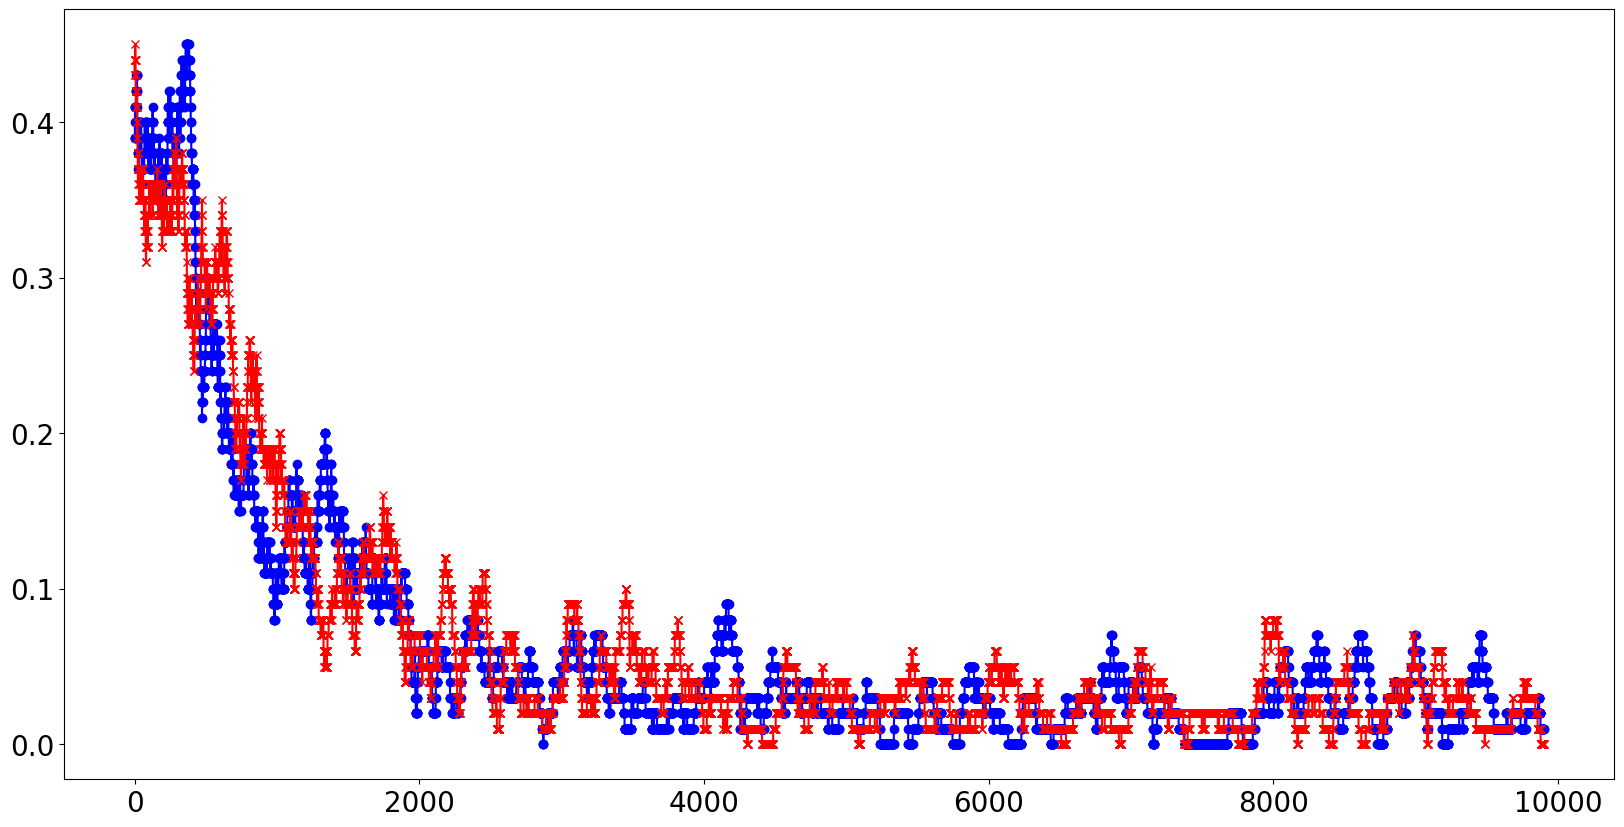

In [28]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(actions)[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(actions)[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()

- Almost immediately the value of C is recognized
- Gradually both end up at (C,C)
- No discounting